# Part C: Results and Figures
# Introduction
This notebook contains the code used to evaluate the results and generate some of the figures in the paper:  "Evaluating the E-OBS meteorological forcing data quality for large-sample hydrology studies in Europe" paper by Clerc-Schwarzenbach and do Nascimento et al. (in review). To be able to run this notebook, please ensure that you have downloaded the acompanying data of the paper. All links can be found in the data section of the paper.

Author: Thiago Nascimento (thiago.nascimento@eawag.ch)

# Import modules

In [1]:
import pandas as pd
import numpy as np
import os
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib as mpl
import warnings
from sklearn.preprocessing import LabelEncoder
warnings.simplefilter(action='ignore', category=Warning)


# Configurations

In [2]:
# Only editable variables:
# Relative path to your local directory
PATH = ".."

# Set the directory:
os.chdir(PATH)

In [3]:
path_estreams = r'/Users/nascimth/Documents/data/EStreams'

# Import data

### - Network information

In [4]:
network_estreams = pd.read_csv(path_estreams+'/streamflow_gauges/estreams_gauging_stations.csv', encoding='utf-8')
network_estreams.set_index("basin_id", inplace = True)

# Convert 'date_column' and 'time_column' to datetime
network_estreams['start_date'] = pd.to_datetime(network_estreams['start_date'])
network_estreams['end_date'] = pd.to_datetime(network_estreams['end_date'])

network_estreams

,gauge_id,gauge_name,gauge_country,gauge_provider,river,lon_snap,lat_snap,lon,lat,elevation,...,num_continuous_days,num_days_gaps,num_days_reliable,num_days_noflag,num_days_suspect,gauge_flag,duplicated_suspect,watershed_group,gauges_upstream,nested_catchments
basin_id,,,,,,,,,,,,,,,,,,,,,
AT000001,200014,Bangs,AT,AT_EHYD,Rhein,9.534835,47.273748,9.534835,47.273748,420,...,9497,0.0,0.0,9497.0,0.0,B,['CH000197'],1,16,"['AT000001', 'CH000010', 'CH000046', 'CH000048..."
AT000002,200048,Schruns (Vonbunweg),AT,AT_EHYD,Litz,9.913677,47.080301,9.913677,47.080301,673,...,23103,0.0,0.0,23103.0,0.0,B,['CH000221'],1,1,['AT000002']
AT000003,231662,Loruens-Aeule,AT,AT_EHYD,Ill,9.847765,47.132821,9.847765,47.132821,579,...,13513,0.0,0.0,13513.0,0.0,B,['CH000215'],1,2,"['AT000002', 'AT000003', 'CH000221']"
AT000004,200592,Kloesterle (OEBB),AT,AT_EHYD,Alfenz,10.061843,47.128994,10.061843,47.128994,1014,...,8765,0.0,0.0,8765.0,0.0,B,['CH000227'],1,1,['AT000004']
AT000005,200097,Buers (Bruecke L82),AT,AT_EHYD,Alvier,9.802668,47.150770,9.802668,47.150770,564,...,10957,0.0,0.0,10957.0,0.0,B,['CH000214'],1,3,"['AT000005', 'CH000214']"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
UAGR0017,6682300,BASHTANOVKA,UA,UA_GRDC,KACHA,33.894739,44.691884,33.900000,44.683333,NaN,...,3652,0.0,0.0,3652.0,0.0,B,NaN,1988,1,['UAGR0017']
UAGR0018,6682500,YALTA,UA,UA_GRDC,DERE-KIOY,34.166667,44.500000,34.166667,44.500000,16,...,3652,0.0,0.0,3652.0,0.0,B,NaN,1989,1,['UAGR0018']
UAGR0019,6683010,PIONERSKOE,UA,UA_GRDC,SALHYR,34.199841,44.887685,34.200000,44.883333,307,...,3652,0.0,0.0,3652.0,0.0,B,NaN,1990,1,['UAGR0019']


In [5]:
estreams_signatures = pd.read_csv(path_estreams+'/hydroclimatic_signatures/estreams_hydrometeo_signatures.csv', encoding='utf-8')
estreams_signatures.set_index("basin_id", inplace = True)

# Mapping dictionary for reclassification
time_mapping = {
    'Fall': 1, 
    'Winter': 2,  
    'Spring': 3,  
    'Summer': 4, 
}

# Reclassify time classes using the mapping dictionary
estreams_signatures['hp_time'] = estreams_signatures['hp_time'].map(time_mapping)
estreams_signatures['lp_time'] = estreams_signatures['lp_time'].map(time_mapping)

# Subset the signatures to be used (only variables, not dates and number of measurments):
estreams_signatures = estreams_signatures.iloc[:, 0:-6]
estreams_signatures

,q_mean,q_runoff_ratio,q_elas_Sankarasubramanian,slope_sawicz,baseflow_index,hfd_mean,hfd_std,q_5,q_95,hq_freq,...,pet_mean,aridity,p_seasonality,frac_snow,hp_freq,hp_dur,hp_time,lp_freq,lp_dur,lp_time
basin_id,,,,,,,,,,,,,,,,,,,,,
AT000001,2.824,0.727,1.266,1.505,0.760,237.600,12.858,1.029,6.607,0.077,...,1.499,0.395,0.309,0.326,13.239,1.172,4.0,198.993,3.561,1.0
AT000002,3.898,1.004,1.223,2.467,0.720,247.952,10.932,0.980,10.727,0.964,...,1.526,0.390,0.331,0.332,15.389,1.215,4.0,204.041,3.576,1.0
AT000003,0.915,0.247,1.802,0.979,0.687,233.361,27.141,0.404,2.819,6.136,...,1.516,0.411,0.346,0.337,15.212,1.203,4.0,202.001,3.592,1.0
AT000004,5.079,1.319,0.324,2.188,0.747,242.783,10.736,1.499,13.295,0.042,...,1.445,0.384,0.338,0.361,15.956,1.217,4.0,205.803,3.598,1.0
AT000005,3.319,0.806,0.820,1.967,0.756,239.207,14.642,1.064,7.692,0.233,...,1.814,0.448,0.328,0.200,15.266,1.186,4.0,201.796,3.547,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
UAGR0017,0.150,0.088,2.387,NaN,0.354,189.111,72.114,0.000,0.797,81.511,...,2.196,1.354,-0.276,0.183,21.817,1.264,2.0,270.637,5.789,4.0
UAGR0018,0.475,0.266,2.041,NaN,0.207,160.444,42.925,0.000,3.631,60.508,...,2.148,1.270,-0.290,0.198,21.849,1.263,2.0,268.322,5.700,4.0
UAGR0019,0.312,0.194,2.893,NaN,0.354,184.667,59.422,0.000,1.412,127.517,...,2.216,1.494,-0.157,0.172,22.917,1.271,2.0,273.598,5.876,4.0


In [6]:
estreams_meteodensity = pd.read_csv(path_estreams+'//attributes/static_attributes/estreams_meteorology_density.csv', encoding='utf-8')
estreams_meteodensity.set_index("basin_id", inplace = True)

## Here we select only these variables as representative:
estreams_meteodensity = estreams_meteodensity[["stations_num_p_mean", "stations_num_t_mean"]]

estreams_meteodensity.head()

,stations_num_p_mean,stations_num_t_mean
basin_id,,
AT000001,22.0,23.0
AT000002,14.0,13.0
AT000003,18.0,18.0
AT000004,7.0,8.0
AT000005,10.0,10.0


In [7]:
estreams_topography = pd.read_csv(path_estreams+'//attributes/static_attributes/estreams_topography_attributes.csv', encoding='utf-8')
estreams_topography.set_index("basin_id", inplace = True)
estreams_topography

,ele_mt_max,ele_mt_mean,ele_mt_min,slp_dg_mean,flat_area_fra,steep_area_fra,elon_ratio,strm_dens
basin_id,,,,,,,,
AT000001,3555.408,1874.076,420.622,24.122,3.395,78.590,0.612,0.151
AT000002,2803.984,1773.178,674.209,26.095,0.463,87.662,0.539,0.151
AT000003,3293.054,1843.003,583.510,25.735,1.497,82.952,0.577,0.141
AT000004,2878.033,1890.429,1022.324,27.324,0.351,88.023,0.587,0.095
AT000005,2938.964,1772.902,567.275,28.647,1.719,83.629,0.612,0.134
...,...,...,...,...,...,...,...,...
UAGR0017,1537.278,564.291,161.399,11.810,4.283,24.393,0.634,0.129
UAGR0018,1511.835,749.565,16.793,19.438,2.114,61.735,0.621,0.024
UAGR0019,1449.416,653.127,306.877,9.655,17.055,20.545,0.739,0.112


In [8]:
estreams_hydrology = pd.read_csv(path_estreams+'//attributes/static_attributes/estreams_hydrology_attributes.csv', encoding='utf-8')
estreams_hydrology.set_index("basin_id", inplace = True)

# Here we select only these variables as representative
estreams_hydrology = estreams_hydrology[["dam_num", "res_num", "lakes_num", "lakes_tot_area", "lakes_tot_vol"]]
estreams_hydrology

,dam_num,res_num,lakes_num,lakes_tot_area,lakes_tot_vol
basin_id,,,,,
AT000001,23.0,10.0,10.0,6.62,542.33
AT000002,0.0,0.0,0.0,0.00,0.00
AT000003,4.0,4.0,3.0,1.46,12.91
AT000004,0.0,0.0,0.0,0.00,0.00
AT000005,1.0,1.0,1.0,0.89,8.27
...,...,...,...,...,...
UAGR0017,0.0,0.0,1.0,1.43,16.43
UAGR0018,0.0,0.0,0.0,0.00,0.00
UAGR0019,0.0,0.0,1.0,0.31,1.54


In [9]:
estreams_soil = pd.read_csv(path_estreams+'/attributes/static_attributes/estreams_soil_attributes.csv', encoding='utf-8')
estreams_soil.set_index("basin_id", inplace = True)

# Here we select only these variables as representative
estreams_soil = estreams_soil[['root_dep_mean', 'root_dep_max', 'root_dep_min',
       'soil_tawc_mean', 'soil_fra_sand_mean', 'soil_fra_silt_mean',
       'soil_fra_clay_mean', 'soil_fra_grav_mean', 'soil_bd_mean','soil_oc_mean']]

estreams_soil

,root_dep_mean,root_dep_max,root_dep_min,soil_tawc_mean,soil_fra_sand_mean,soil_fra_silt_mean,soil_fra_clay_mean,soil_fra_grav_mean,soil_bd_mean,soil_oc_mean
basin_id,,,,,,,,,,
AT000001,81.571,130.0,0.0,28.738,58.196,16.337,7.973,9.062,1.303,1.218
AT000002,58.600,70.0,30.0,46.474,54.920,29.650,15.430,8.140,1.502,1.820
AT000003,51.660,130.0,0.0,45.044,49.262,30.836,16.883,10.294,1.425,1.714
AT000004,49.412,70.0,30.0,49.256,39.956,40.088,19.956,13.044,1.409,1.771
AT000005,31.781,100.0,0.0,44.098,39.795,38.151,20.685,17.658,1.384,1.836
...,...,...,...,...,...,...,...,...,...,...
UAGR0017,128.620,130.0,40.0,51.371,23.184,29.245,47.571,9.939,1.246,1.198
UAGR0018,73.061,130.0,40.0,64.165,30.592,39.122,30.286,7.469,1.066,2.340
UAGR0019,130.000,130.0,130.0,51.029,23.115,29.123,47.761,10.049,1.251,1.178


In [10]:
estreams_landcover = pd.read_csv(path_estreams+'//attributes/temporal_attributes/estreams_landcover_attributes.csv', encoding='utf-8')
estreams_landcover.set_index("basin_id", inplace = True)
estreams_landcover

# We have more than 20 classes, so it is better if we aggregate the classes in more representative ones:
# * 1. Urban, 2. Non irrigated aggriculture, 3. Irrigated aggriculture, 4. grassland and 5. forests

def aggregate_columns(df, years):
    # Initialize a dictionary to store aggregated columns
    aggregated_columns = {}

    # Iterate through each year
    for year in years:
        # Iterate through each column in the DataFrame
        for column in df.columns:
            # Check if the column name contains the specified year and the number is between 300 and 315 for forest
            if f'_{year}_' in column and 300 <= int(column.split('_')[-1]) < 315:
                prefix = '_'.join(column.split('_')[:-1]) + "_forest"
                if prefix in aggregated_columns:
                    aggregated_columns[prefix].append(column)
                else:
                    aggregated_columns[prefix] = [column]
            # Check if the column name contains the specified year and the number is between 315 and 400 for grass
            elif f'_{year}_' in column and 315 <= int(column.split('_')[-1]) < 400:
                prefix = '_'.join(column.split('_')[:-1]) + "_grass"
                if prefix in aggregated_columns:
                    aggregated_columns[prefix].append(column)
                else:
                    aggregated_columns[prefix] = [column]
            # Check if the column name contains the specified year and the number is between 200 and 300 for agriculture
            elif f'_{year}_' in column and 212 <= int(column.split('_')[-1]) < 300:
                prefix = '_'.join(column.split('_')[:-1]) + "_Agric"
                if prefix in aggregated_columns:
                    aggregated_columns[prefix].append(column)
                else:
                    aggregated_columns[prefix] = [column]
        
            # Check if the column name contains the specified year and the number is between 200 and 300 for agriculture
            elif f'_{year}_' in column and 200 <= int(column.split('_')[-1]) < 212:
                prefix = '_'.join(column.split('_')[:-1]) + "_NonIrriAgri"
                if prefix in aggregated_columns:
                    aggregated_columns[prefix].append(column)
                else:
                    aggregated_columns[prefix] = [column]

             # Check if the column name contains the specified year and the number is between 200 and 300 for agriculture
            elif f'_{year}_' in column and 111 <= int(column.split('_')[-1]) <= 124:
                prefix = '_'.join(column.split('_')[:-1]) + "_urban"
                if prefix in aggregated_columns:
                    aggregated_columns[prefix].append(column)
                else:
                    aggregated_columns[prefix] = [column]                   
    # Iterate through the aggregated_columns dictionary and create new aggregated columns
    for prefix, columns in aggregated_columns.items():
        # Aggregate the columns by summing them along the columns axis
        df[prefix] = df[columns].sum(axis=1)
        # Drop the original columns
        df.drop(columns, axis=1, inplace=True)

# List of years to iterate over
years = [1990, 2000, 2006, 2012, 2018]

# Call the function to aggregate columns for each year
aggregate_columns(estreams_landcover, years)


# Filter only the columns already resampled:
estreams_landcover = estreams_landcover.iloc[:, -25:]

# Subset only one year to avoid co-correlation
estreams_landcover = estreams_landcover[["lulc_2006_urban", "lulc_2006_NonIrriAgri", "lulc_2006_Agric", "lulc_2006_forest", 
                                         "lulc_2006_grass"]]
estreams_landcover["lulc_2006_agriculture"] = estreams_landcover.lulc_2006_NonIrriAgri + estreams_landcover.lulc_2006_Agric

estreams_landcover.head()

,lulc_2006_urban,lulc_2006_NonIrriAgri,lulc_2006_Agric,lulc_2006_forest,lulc_2006_grass,lulc_2006_agriculture
basin_id,,,,,,
AT000001,0.020,0.019,0.108,0.268,0.581,0.127
AT000002,0.029,0.000,0.051,0.331,0.577,0.051
AT000003,0.031,0.000,0.040,0.269,0.647,0.040
AT000004,0.023,0.000,0.031,0.177,0.739,0.031
AT000005,0.017,0.000,0.023,0.283,0.624,0.023


In [11]:
estreams_vegetation= pd.read_csv(path_estreams+"//attributes/static_attributes/estreams_vegetation_attributes.csv", encoding='utf-8')
estreams_vegetation.set_index("basin_id", inplace = True)

# Here we select only these two variables as representative
estreams_vegetation = estreams_vegetation[["lai_mean", "ndvi_mean"]]
estreams_vegetation

,lai_mean,ndvi_mean
basin_id,,
AT000001,0.092,0.329
AT000002,0.089,0.342
AT000003,0.087,0.313
AT000004,0.073,0.276
AT000005,0.086,0.311
...,...,...
UAGR0017,0.195,0.599
UAGR0018,0.152,0.576
UAGR0019,0.145,0.535


In [12]:
estreams_snowcover = pd.read_csv(path_estreams+"//attributes/static_attributes/estreams_snowcover_attributes.csv", encoding='utf-8')
estreams_snowcover.set_index("basin_id", inplace = True)

# Here we select only these two variables as representative
estreams_snowcover = estreams_snowcover[["sno_cov_mean"]]
estreams_snowcover

,sno_cov_mean
basin_id,
AT000001,33.844
AT000002,36.284
AT000003,36.927
AT000004,40.210
AT000005,34.486
...,...
UAGR0017,3.805
UAGR0018,6.159
UAGR0019,4.928


In [13]:
performances = pd.read_csv("data/performances.txt", sep="\t")
performances.set_index("id", inplace=True)
performances

,p_camels_tq/evap_camels,p_estreams_tq/evap_camels,p_t_camels_q/evap_camels,p_t_estreams_q/evap_camels,pt_q_camels/evap_camels,pt_q_estreams/evap_camels,ptq_camels/evap_camels,ptq_estreams/evap_camels,p_camels_tq/evap_estreams,p_estreams_tq/evap_estreams,p_t_camels_q/evap_estreams,p_t_estreams_q/evap_estreams,pt_q_camels/evap_estreams,pt_q_estreams/evap_estreams,ptq_camels/evap_estreams,ptq_estreams/evap_estreams,color,cam_min_estr
id,,,,,,,,,,,,,,,,,,
AT000002,0.912559,0.878612,0.880653,0.913105,0.900589,0.898155,0.896840,0.899162,0.913757,0.884673,0.886666,0.913440,0.903629,0.893866,0.898206,0.900268,pink,-0.003428
AT000003,-0.847771,-0.203314,-0.181490,-0.834960,-0.177242,-0.772337,-0.814603,-0.191492,-0.873919,-0.247793,-0.251435,-0.882307,-0.208316,-0.847132,-0.831916,-0.202786,pink,-0.611817
AT000005,0.877461,0.876717,0.873821,0.880424,0.887318,0.871989,0.872962,0.888593,0.880978,0.874935,0.875113,0.881777,0.884695,0.873326,0.874370,0.885210,pink,-0.012248
AT000006,0.856988,0.763575,0.760387,0.858968,0.772780,0.839222,0.841662,0.770377,0.857782,0.761512,0.758773,0.859790,0.769599,0.842745,0.842049,0.768985,pink,0.072677
AT000007,0.604909,0.824089,0.826503,0.603074,0.846021,0.572963,0.571124,0.840672,0.602373,0.831248,0.830191,0.606975,0.837836,0.576859,0.575120,0.850400,pink,-0.279275
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SE000252,0.619505,0.948688,0.550172,0.958501,0.952875,0.614139,0.957227,0.554647,0.669618,0.958916,0.603327,0.960808,0.959033,0.664761,0.961166,0.603316,black,0.353911
SE000277,0.847042,0.815408,0.816995,0.845324,0.814350,0.845970,0.846135,0.816816,0.866532,0.845474,0.853202,0.866861,0.852023,0.868283,0.866692,0.855229,black,-0.009094
SE000283,0.890972,0.815181,0.800837,0.898393,0.806755,0.891417,0.897218,0.795021,0.917508,0.857763,0.850256,0.917493,0.861439,0.920629,0.920063,0.846725,black,0.050493


In [14]:
hydmet = pd.read_csv("data/hydmet.txt", sep="\t")
hydmet.set_index("id", inplace=True)
hydmet['aridity_estreams'] = hydmet['Epot_sum_Estr']/ hydmet['P_sum_Estr']
hydmet['aridity_camels'] = hydmet['Epot_sum_CAM']/ hydmet['P_sum_CAM']

hydmet

,P_sum_CAM,P_sum_Estr,rel_diff_P,T_mean_CAM,T_mean_Estr,T_diff,Epot_sum_CAM,Epot_sum_Estr,rel_diff_Epot,aridity_estreams,aridity_camels
id,,,,,,,,,,,
AT000002,1807.834000,1477.9270,-18.248744,1.314730,3.340846,2.026116,487.815000,572.7165,17.404446,0.387513,0.269834
AT000003,1735.892000,1391.9735,-19.812206,0.675633,2.969826,2.294193,468.139000,571.1655,22.007673,0.410328,0.269682
AT000005,1873.880000,1493.7300,-20.286785,3.280287,6.134170,2.853882,544.950500,682.3930,25.221098,0.456838,0.290814
AT000006,1887.215000,1622.8675,-14.007281,2.906092,4.903155,1.997064,530.054500,638.9330,20.541001,0.393706,0.280866
AT000007,1802.942000,1465.2465,-18.730248,1.967091,4.062658,2.095567,505.757500,608.6820,20.350563,0.415413,0.280518
...,...,...,...,...,...,...,...,...,...,...,...
SE000252,1089.536490,1006.1435,-7.653988,6.739536,6.750089,0.010553,826.670388,588.4115,-28.821510,0.584819,0.758736
SE000277,978.482663,881.6085,-9.900448,6.458892,6.315325,-0.143567,808.595891,602.1640,-25.529673,0.683029,0.826377
SE000283,960.877277,846.3640,-11.917576,1.252791,1.692538,0.439747,674.958151,483.5885,-28.352817,0.571372,0.702439


In [45]:
hydmet

,P_sum_CAM,P_sum_Estr,rel_diff_P,T_mean_CAM,T_mean_Estr,T_diff,Epot_sum_CAM,Epot_sum_Estr,rel_diff_Epot,aridity_estreams,aridity_camels
id,,,,,,,,,,,
AT000002,1807.834000,1477.9270,-18.248744,1.314730,3.340846,2.026116,487.815000,572.7165,17.404446,0.387513,0.269834
AT000003,1735.892000,1391.9735,-19.812206,0.675633,2.969826,2.294193,468.139000,571.1655,22.007673,0.410328,0.269682
AT000005,1873.880000,1493.7300,-20.286785,3.280287,6.134170,2.853882,544.950500,682.3930,25.221098,0.456838,0.290814
AT000006,1887.215000,1622.8675,-14.007281,2.906092,4.903155,1.997064,530.054500,638.9330,20.541001,0.393706,0.280866
AT000007,1802.942000,1465.2465,-18.730248,1.967091,4.062658,2.095567,505.757500,608.6820,20.350563,0.415413,0.280518
...,...,...,...,...,...,...,...,...,...,...,...
SE000252,1089.536490,1006.1435,-7.653988,6.739536,6.750089,0.010553,826.670388,588.4115,-28.821510,0.584819,0.758736
SE000277,978.482663,881.6085,-9.900448,6.458892,6.315325,-0.143567,808.595891,602.1640,-25.529673,0.683029,0.826377
SE000283,960.877277,846.3640,-11.917576,1.252791,1.692538,0.439747,674.958151,483.5885,-28.352817,0.571372,0.702439


In [16]:


# Concatenate horizontally
network_basins = pd.concat([network_estreams, performances, estreams_signatures, estreams_topography,
                                           estreams_soil, estreams_vegetation, estreams_landcover,
                                           estreams_hydrology, estreams_snowcover, estreams_meteodensity], axis=1)

network_basins = network_basins.loc[performances.index]

network_basins

,gauge_id,gauge_name,gauge_country,gauge_provider,river,lon_snap,lat_snap,lon,lat,elevation,...,lulc_2006_grass,lulc_2006_agriculture,dam_num,res_num,lakes_num,lakes_tot_area,lakes_tot_vol,sno_cov_mean,stations_num_p_mean,stations_num_t_mean
id,,,,,,,,,,,,,,,,,,,,,
AT000002,200048,Schruns (Vonbunweg),AT,AT_EHYD,Litz,9.913677,47.080301,9.913677,47.080301,673,...,0.577,0.051,0.0,0.0,0.0,0.00,0.00,36.284,14.0,13.0
AT000003,231662,Loruens-Aeule,AT,AT_EHYD,Ill,9.847765,47.132821,9.847765,47.132821,579,...,0.647,0.040,4.0,4.0,3.0,1.46,12.91,36.927,18.0,18.0
AT000005,200097,Buers (Bruecke L82),AT,AT_EHYD,Alvier,9.802668,47.150770,9.802668,47.150770,564,...,0.624,0.023,1.0,1.0,1.0,0.89,8.27,34.486,10.0,10.0
AT000006,200105,Garsella,AT,AT_EHYD,Lutz,9.875898,47.226658,9.875898,47.226658,730,...,0.661,0.058,0.0,0.0,0.0,0.00,0.00,33.031,15.0,14.0
AT000007,231688,Beschling,AT,AT_EHYD,Ill,9.678850,47.200301,9.678850,47.200301,485,...,0.559,0.058,7.0,6.0,5.0,2.67,23.90,32.887,40.0,38.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SE000252,257,MUNKEDAL 2,SE,SE_SMHI,ÖREKILSÄLVEN,11.683300,58.463600,11.683300,58.463600,NaN,...,0.069,0.178,0.0,0.0,36.0,19.61,216.56,11.133,10.0,5.0
SE000277,364,HILLARED,SE,SE_SMHI,ÄTRAN,13.141300,57.607300,13.141300,57.607300,NaN,...,0.034,0.234,0.0,0.0,29.0,50.78,541.40,13.610,12.0,8.0
SE000283,654,ERSBO,SE,SE_SMHI,VÄSTERDALÄLVEN,13.011000,61.307600,13.011000,61.307600,NaN,...,0.433,0.005,0.0,0.0,15.0,3.35,14.59,35.366,10.0,6.0


In [17]:
network_basins = network_basins[network_basins.q_runoff_ratio <= 1.1]

In [18]:
network_basins.groupby("gauge_country").count()

,gauge_id,gauge_name,gauge_provider,river,lon_snap,lat_snap,lon,lat,elevation,area_official,...,lulc_2006_grass,lulc_2006_agriculture,dam_num,res_num,lakes_num,lakes_tot_area,lakes_tot_vol,sno_cov_mean,stations_num_p_mean,stations_num_t_mean
gauge_country,,,,,,,,,,,,,,,,,,,,,
AT,428,428,428,428,428,428,428,428,428,428,...,428,428,428,428,428,428,428,428,428,428
CH,162,162,162,162,162,162,162,162,162,162,...,162,162,162,162,162,162,162,162,162,162
CZ,297,297,297,297,297,297,297,297,0,297,...,297,297,297,297,297,297,297,297,297,297
DE,1054,1054,1054,896,1054,1054,1054,1054,816,1049,...,1054,1054,1054,1054,1054,1054,1054,1054,1054,1054
DK,139,139,139,139,139,139,139,139,0,139,...,139,139,139,139,139,139,139,139,139,139
ES,245,245,245,0,245,245,245,245,245,245,...,245,245,245,245,245,245,245,245,245,245
FR,515,515,515,515,515,515,515,515,510,512,...,515,515,515,515,515,515,515,515,515,515
GB,560,560,560,560,560,560,560,560,560,560,...,560,560,560,560,560,560,560,560,560,560
SE,23,23,23,23,23,23,23,23,0,23,...,23,23,23,23,23,23,23,23,23,23


In [19]:
#network_basins.index.name="basin_id"
#network_basins.to_csv("results/list_filtered_3423.csv", encoding='utf-8')

In [20]:
#world = gpd.read_file(r"C:\Users\nascimth\Documents\data\gis\world.shp")


In [46]:
network_basins["diff"] = network_basins['pt_q_camels/evap_estreams']-network_basins['ptq_camels/evap_camels']
network_basins['estreams_kges'] = network_basins['pt_q_camels/evap_estreams']
network_basins["camels_kges"] = network_basins['ptq_camels/evap_camels']
network_basins['aridity_estreams'] = hydmet['aridity_estreams']
network_basins['aridity_camels'] = hydmet['aridity_camels'] 

network_basins

,gauge_id,gauge_name,gauge_country,gauge_provider,river,lon_snap,lat_snap,lon,lat,elevation,...,lakes_tot_area,lakes_tot_vol,sno_cov_mean,stations_num_p_mean,stations_num_t_mean,diff,estreams_kges,camels_kges,aridity_estreams,aridity_camels
id,,,,,,,,,,,,,,,,,,,,,
AT000002,200048,Schruns (Vonbunweg),AT,AT_EHYD,Litz,9.913677,47.080301,9.913677,47.080301,673,...,0.00,0.00,36.284,14.0,13.0,0.006789,0.903629,0.896840,0.387513,0.269834
AT000003,231662,Loruens-Aeule,AT,AT_EHYD,Ill,9.847765,47.132821,9.847765,47.132821,579,...,1.46,12.91,36.927,18.0,18.0,0.606287,-0.208316,-0.814603,0.410328,0.269682
AT000005,200097,Buers (Bruecke L82),AT,AT_EHYD,Alvier,9.802668,47.150770,9.802668,47.150770,564,...,0.89,8.27,34.486,10.0,10.0,0.011733,0.884695,0.872962,0.456838,0.290814
AT000007,231688,Beschling,AT,AT_EHYD,Ill,9.678850,47.200301,9.678850,47.200301,485,...,2.67,23.90,32.887,40.0,38.0,0.266711,0.837836,0.571124,0.415413,0.280518
AT000008,200501,Amerluegen,AT,AT_EHYD,Samina,9.614203,47.205978,9.614203,47.205978,603,...,0.00,0.00,27.201,8.0,6.0,0.235233,0.813583,0.578351,0.487081,0.321851
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SE000091,200,RÖRVIK,SE,SE_SMHI,ALLGUNNEN,14.585100,57.242100,14.585100,57.242100,NaN,...,26.34,184.11,14.816,4.0,1.0,0.006283,0.936235,0.929952,0.824595,0.973800
SE000277,364,HILLARED,SE,SE_SMHI,ÄTRAN,13.141300,57.607300,13.141300,57.607300,NaN,...,50.78,541.40,13.610,12.0,8.0,0.005889,0.852023,0.846135,0.683029,0.826377
SE000283,654,ERSBO,SE,SE_SMHI,VÄSTERDALÄLVEN,13.011000,61.307600,13.011000,61.307600,NaN,...,3.35,14.59,35.366,10.0,6.0,-0.035779,0.861439,0.897218,0.571372,0.702439


In [47]:
# Group by 'country' and calculate mean, median, std, count for selected columns
stats_per_country = network_basins.groupby("gauge_country")[["camels_kges", "estreams_kges", "aridity_estreams","aridity_camels"]].agg(
    ["mean", "median", "min", "max", "count"]
)
stats_per_country

camels_kges                                      estreams_kges  \
                     mean    median        min       max count          mean   
gauge_country                                                                  
AT               0.696010  0.781445  -2.136814  0.927181   428      0.806235   
CH               0.755136  0.887764  -2.932365  0.956203   162      0.734166   
CZ               0.846983  0.868554   0.181634  0.963030   297      0.823197   
DE               0.861191  0.896716  -3.880458  0.963254  1054      0.856414   
DK               0.802916  0.855149  -0.342176  0.951277   139      0.826728   
ES               0.728913  0.831426  -4.372401  0.951199   245      0.593613   
FR               0.856633  0.900053  -3.500369  0.967665   515      0.886736   
GB               0.814960  0.906148 -11.450247  0.978767   560      0.830769   
SE               0.913388  0.919969   0.810975  0.967595    23      0.908359   

                                                  aridity_estreams            \
                 median       min       max count             mean    median   
gauge_country                                                                  
AT             0.857496 -1.766190  0.944190   428         0.728765  0.683711   
CH             0.838973 -4.069620  0.940110   162         0.557695  0.547172   
CZ             0.843151  0.338258  0.962021   297         1.082295  1.089782   
DE             0.884878 -2.503091  0.962854  1054         0.953975  0.934183   
DK             0.837256  0.531741  0.953721   139         0.845309  0.855757   
ES             0.659766 -2.520436  0.935707   245         1.839317  1.818000   
FR             0.907485  0.068985  0.969488   515         0.929633  0.927847   
GB             0.856139 -0.331563  0.960655   560         0.769955  0.769558   
SE             0.913517  0.816841  0.968484    23         0.736604  0.762719   

                                        aridity_camels                      \
                    min       max count           mean    median       min   
gauge_country                                                                
AT             0.320910  1.655090   428       0.548642  0.526411  0.238707   
CH             0.279575  0.971329   162       0.443611  0.422453  0.241379   
CZ             0.625467  1.723789   297       0.741629  0.763837  0.365032   
DE             0.363233  1.527325  1054       0.851707  0.842392  0.319725   
DK             0.677998  1.015243   139       0.692028  0.662549  0.524106   
ES             0.537120  3.492637   245       1.434838  1.359558  0.419557   
FR             0.399215  1.618318   515       0.689993  0.694032  0.280917   
GB             0.227527  1.352457   560       0.538807  0.533091  0.129351   
SE             0.534570  1.037942    23       0.921330  0.973800  0.649912   

                               
                    max count  
gauge_country                  
AT             1.126565   428  
CH             0.844057   162  
CZ             1.220463   297  
DE             1.446322  1054  
DK             0.939388   139  
ES             3.310344   245  
FR             1.230612   515  
GB             0.944025   560  
SE             1.182970    23

In [23]:
network_basins

,gauge_id,gauge_name,gauge_country,gauge_provider,river,lon_snap,lat_snap,lon,lat,elevation,...,lakes_tot_area,lakes_tot_vol,sno_cov_mean,stations_num_p_mean,stations_num_t_mean,diff,estreams_kges,camels_kges,aridity_estreams,aridity_camels
id,,,,,,,,,,,,,,,,,,,,,
AT000002,200048,Schruns (Vonbunweg),AT,AT_EHYD,Litz,9.913677,47.080301,9.913677,47.080301,673,...,0.00,0.00,36.284,14.0,13.0,0.006789,0.903629,0.896840,0.387513,0.269834
AT000003,231662,Loruens-Aeule,AT,AT_EHYD,Ill,9.847765,47.132821,9.847765,47.132821,579,...,1.46,12.91,36.927,18.0,18.0,0.606287,-0.208316,-0.814603,0.410328,0.269682
AT000005,200097,Buers (Bruecke L82),AT,AT_EHYD,Alvier,9.802668,47.150770,9.802668,47.150770,564,...,0.89,8.27,34.486,10.0,10.0,0.011733,0.884695,0.872962,0.456838,0.290814
AT000007,231688,Beschling,AT,AT_EHYD,Ill,9.678850,47.200301,9.678850,47.200301,485,...,2.67,23.90,32.887,40.0,38.0,0.266711,0.837836,0.571124,0.415413,0.280518
AT000008,200501,Amerluegen,AT,AT_EHYD,Samina,9.614203,47.205978,9.614203,47.205978,603,...,0.00,0.00,27.201,8.0,6.0,0.235233,0.813583,0.578351,0.487081,0.321851
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SE000091,200,RÖRVIK,SE,SE_SMHI,ALLGUNNEN,14.585100,57.242100,14.585100,57.242100,NaN,...,26.34,184.11,14.816,4.0,1.0,0.006283,0.936235,0.929952,0.824595,0.973800
SE000277,364,HILLARED,SE,SE_SMHI,ÄTRAN,13.141300,57.607300,13.141300,57.607300,NaN,...,50.78,541.40,13.610,12.0,8.0,0.005889,0.852023,0.846135,0.683029,0.826377
SE000283,654,ERSBO,SE,SE_SMHI,VÄSTERDALÄLVEN,13.011000,61.307600,13.011000,61.307600,NaN,...,3.35,14.59,35.366,10.0,6.0,-0.035779,0.861439,0.897218,0.571372,0.702439


In [50]:
network_basins.describe().iloc[:, -4:]

,estreams_kges,camels_kges,aridity_estreams,aridity_camels
count,3423.000000,3423.000000,3423.000000,3423.000000
mean,0.822172,0.814553,0.941922,0.745148
min,-4.069620,-11.450247,0.227527,0.129351
25%,0.803497,0.819806,0.691508,0.529619
50%,0.866801,0.883158,0.896700,0.708056
75%,0.905363,0.917705,1.090619,0.879554
max,0.969488,0.978767,3.492637,3.310344
std,0.201176,0.369015,0.414636,0.346177


In [39]:
stats_per_country.mean()

camels_kges       mean        0.808459
                  median      0.871914
                  min        -3.069136
                  max         0.958463
                  count     380.333333
estreams_kges     mean        0.807358
                  median      0.844296
                  min        -1.048342
                  max         0.955248
                  count     380.333333
aridity_estreams  mean        0.938172
                  median      0.932081
                  min         0.440624
                  max         1.599348
                  count     380.333333
aridity_camels    mean        0.762509
                  median      0.753125
                  min         0.352076
                  max         1.360527
                  count     380.333333
dtype: float64

In [40]:
network_basins[["estreams_kges", "camels_kges"]].mean()

estreams_kges    0.822172
camels_kges      0.814553
dtype: float64

In [24]:
# Count of camels_kges > 0.70 per country
count_camels_gt_070 = (
    network_basins[network_basins["camels_kges"] > 0.70]
    .groupby("gauge_country")
    .size()
    .reset_index(name="count_camels_kges_gt_0.70")
)

# Count of estreams_kge > 0.70 per country
count_streams_gt_070 = (
    network_basins[network_basins["estreams_kges"] > 0.70]
    .groupby("gauge_country")
    .size()
    .reset_index(name="count_estreams_kges_gt_0.70")
)

# Total basins per country
total_per_country = network_basins.groupby("gauge_country").size().reset_index(name="total")

# Merge all into one stats table
stats = (
    total_per_country
    .merge(count_camels_gt_070, on="gauge_country", how="left")
    .merge(count_streams_gt_070, on="gauge_country", how="left")
)

# Fill NaNs with 0
stats[["count_camels_kges_gt_0.70", "count_estreams_kges_gt_0.70"]] = stats[
    ["count_camels_kges_gt_0.70", "count_estreams_kges_gt_0.70"]
].fillna(0).astype(int)

# Add proportions
stats["fraction_camels_gt_0.70"] = stats["count_camels_kges_gt_0.70"] / stats["total"]
stats["fraction_estreams_gt_0.70"] = stats["count_estreams_kges_gt_0.70"] / stats["total"]

stats

,gauge_country,total,count_camels_kges_gt_0.70,count_estreams_kges_gt_0.70,fraction_camels_gt_0.70,fraction_estreams_gt_0.70
0,AT,428,295,388,0.689252,0.906542
1,CH,162,142,133,0.876543,0.820988
2,CZ,297,276,273,0.929293,0.919192
3,DE,1054,1010,998,0.958254,0.946869
4,DK,139,125,131,0.899281,0.942446
5,ES,245,191,100,0.779592,0.408163
6,FR,515,484,502,0.939806,0.974757
7,GB,560,520,511,0.928571,0.912500
8,SE,23,23,23,1.000000,1.000000


In [25]:
stats.sum()

gauge_country                  ATCHCZDEDKESFRGBSE
total                                        3423
count_camels_kges_gt_0.70                    3066
count_estreams_kges_gt_0.70                  3059
fraction_camels_gt_0.70                  8.000592
fraction_estreams_gt_0.70                7.831457
dtype: object

In [26]:
3066/3423

0.8957055214723927

In [27]:
network_basins[["aridity_estreams","aridity_camels", "estreams_kges", "camels_kges"]].corr(method='spearman')

,aridity_estreams,aridity_camels,estreams_kges,camels_kges
aridity_estreams,1.000000,0.910068,-0.102026,-0.182504
aridity_camels,0.910068,1.000000,-0.038445,-0.135087
estreams_kges,-0.102026,-0.038445,1.000000,0.609895
camels_kges,-0.182504,-0.135087,0.609895,1.000000


In [28]:
print(len(network_basins[network_basins["diff"] > 0])/len(network_basins))
print(len(network_basins[network_basins["diff"] < 0])/len(network_basins))

0.3932223196026877
0.6067776803973123


In [53]:
network_basins_noAT = network_basins[network_basins.gauge_country != "AT"]
network_basins_noAT

,gauge_id,gauge_name,gauge_country,gauge_provider,river,lon_snap,lat_snap,lon,lat,elevation,...,lakes_tot_area,lakes_tot_vol,sno_cov_mean,stations_num_p_mean,stations_num_t_mean,diff,estreams_kges,camels_kges,aridity_estreams,aridity_camels
id,,,,,,,,,,,,,,,,,,,,,
CH000006,2020,Bellinzona,CH,CH_CAMELS,Ticino,9.0100,46.1900,9.0100,46.1900,222,...,2.53,175.39,25.186,4.0,11.0,-0.018678,0.878428,0.897106,0.365029,0.408573
CH000010,2033,Ilanz,CH,CH_CAMELS,Vorderrhein,9.2100,46.7800,9.2100,46.7800,700,...,1.88,153.40,38.068,3.0,2.0,-0.015718,0.849307,0.865025,0.311546,0.325136
CH000011,2034,Payerne-Caserne_d'aviation,CH,CH_CAMELS,Broye,6.9400,46.8400,6.9400,46.8400,444,...,0.00,0.00,7.300,2.0,2.0,-0.037261,0.861373,0.898634,0.732332,0.562718
CH000013,2044,Andelfingen,CH,CH_CAMELS,Thur,8.6800,47.6000,8.6800,47.6000,363,...,0.41,1.37,11.867,9.0,7.0,-0.090577,0.843159,0.933737,0.638953,0.414740
CH000014,2053,Martigny-Pont_de_Rossettan,CH,CH_CAMELS,Drance,7.0600,46.1000,7.0600,46.1000,482,...,1.42,231.60,39.710,2.0,3.0,-0.125994,0.564599,0.690593,0.443277,0.397642
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SE000091,200,RÖRVIK,SE,SE_SMHI,ALLGUNNEN,14.5851,57.2421,14.5851,57.2421,NaN,...,26.34,184.11,14.816,4.0,1.0,0.006283,0.936235,0.929952,0.824595,0.973800
SE000277,364,HILLARED,SE,SE_SMHI,ÄTRAN,13.1413,57.6073,13.1413,57.6073,NaN,...,50.78,541.40,13.610,12.0,8.0,0.005889,0.852023,0.846135,0.683029,0.826377
SE000283,654,ERSBO,SE,SE_SMHI,VÄSTERDALÄLVEN,13.0110,61.3076,13.0110,61.3076,NaN,...,3.35,14.59,35.366,10.0,6.0,-0.035779,0.861439,0.897218,0.571372,0.702439


In [54]:
print(len(network_basins_noAT[network_basins_noAT["diff"] >= 0])/len(network_basins_noAT))
print(len(network_basins_noAT[network_basins_noAT["diff"] < 0])/len(network_basins_noAT))

0.3315525876460768
0.6684474123539232


In [55]:
1 - 54/(54+108)

0.6666666666666667

In [56]:
1 - 296/1054

0.7191650853889944

In [33]:
1- 112/297

0.6228956228956228

In [34]:
1- 114/446

0.7443946188340806

In [35]:
1- 60/(60+79)

0.5683453237410072

In [36]:
len(network_basins[network_basins.gauge_country=="DE"][network_basins["diff"] < -0.05])

85

In [37]:
len(network_basins[network_basins.gauge_country=="DE"][network_basins["diff"] > -0.05])

969

In [38]:
85/(85+969)

0.08064516129032258

In [39]:
len(network_basins[network_basins.gauge_country=="CH"][network_basins["diff"] < -0.05])

58

In [40]:
len(network_basins[network_basins.gauge_country=="CH"][network_basins["diff"] > -0.05])

104

In [41]:
54/(54+104)

0.34177215189873417

In [43]:
network_basins["area"] = network_basins["area_estreams"]

In [44]:
correlations_df = network_basins.iloc[:, 47:].corr(method="spearman")["diff"]

correlations_df[abs(correlations_df)>0.1]

q_mean                      -0.186068
q_runoff_ratio              -0.311866
q_elas_Sankarasubramanian    0.108183
slope_sawicz                -0.148865
baseflow_index               0.114256
hfd_mean                     0.156650
q_95                        -0.198454
lq_dur                      -0.108054
pet_mean                     0.109929
p_seasonality                0.287323
frac_snow                    0.134098
hp_freq                      0.125095
hp_time                      0.148412
lp_time                     -0.180671
root_dep_max                -0.285569
soil_bd_mean                 0.157680
soil_oc_mean                -0.171480
lulc_2006_urban              0.212480
lulc_2006_grass             -0.242805
lulc_2006_agriculture        0.105225
dam_num                     -0.116314
res_num                     -0.119785
stations_num_p_mean          0.261416
stations_num_t_mean          0.397875
diff                         1.000000
estreams_kges                0.400053
camels_kges 

In [29]:
network_basins.iloc[:, 52:]

,hfd_mean,hfd_std,q_5,q_95,hq_freq,hq_dur,lq_freq,lq_dur,zero_q_freq,p_mean,...,dam_num,res_num,lakes_num,lakes_tot_area,lakes_tot_vol,sno_cov_mean,stations_num_p_mean,stations_num_t_mean,diff,area
basin_id,,,,,,,,,,,,,,,,,,,,,
AT000002,247.952,10.932,0.980,10.727,0.964,2.440,5.470,13.308,0.0,3.912,...,0.0,0.0,0.0,0.00,0.00,36.284,14.0,13.0,0.006789,102.287
AT000003,233.361,27.141,0.404,2.819,6.136,2.609,NaN,NaN,0.0,3.693,...,4.0,4.0,3.0,1.46,12.91,36.927,18.0,18.0,0.606287,536.299
AT000005,239.207,14.642,1.064,7.692,0.233,1.400,NaN,NaN,0.0,4.048,...,1.0,1.0,1.0,0.89,8.27,34.486,10.0,10.0,0.011733,72.448
AT000007,233.806,15.056,0.689,4.835,0.378,1.556,0.486,2.000,0.0,3.916,...,7.0,6.0,5.0,2.67,23.90,32.887,40.0,38.0,0.266711,1143.768
AT000008,219.167,14.473,0.734,5.643,2.097,1.585,2.194,8.500,0.0,3.930,...,0.0,0.0,0.0,0.00,0.00,27.201,8.0,6.0,0.235233,69.361
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SE000091,170.611,33.217,0.102,1.791,NaN,NaN,37.776,52.226,0.0,1.909,...,0.0,0.0,20.0,26.34,184.11,14.816,4.0,1.0,0.006283,160.157
SE000277,154.153,27.428,0.357,2.744,NaN,NaN,2.989,12.167,0.0,2.253,...,0.0,0.0,29.0,50.78,541.40,13.610,12.0,8.0,0.005889,774.258
SE000283,227.417,13.739,0.469,6.202,3.631,2.891,5.514,19.238,0.0,2.135,...,0.0,0.0,15.0,3.35,14.59,35.366,10.0,6.0,-0.035779,1086.581


In [41]:
import matplotlib.pyplot as plt

# Assuming your DataFrame is named df and has 'aridity', 'diff', and 'color' columns
plt.figure(figsize=(8, 6))

# Scatter plot using the 'color' column for coloring
plt.scatter(network_basins["area"], network_basins["diff"], c=network_basins["color"], edgecolor="none", s=60, alpha=0.8)

plt.xlabel("q_runoff_ratio")
plt.ylabel("Diff")
plt.title("Diff vs. Aridity Colored by Category")
plt.ylim(-0.5, 0.5)
plt.grid(True)
plt.tight_layout()

plt.show()


KeyError: 'area'

<Figure size 800x600 with 0 Axes>

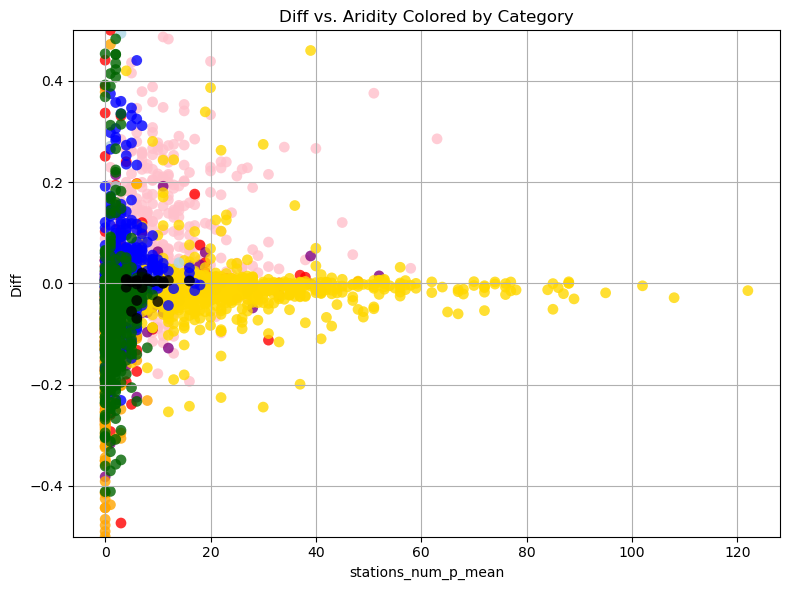

In [42]:
import matplotlib.pyplot as plt

# Assuming your DataFrame is named df and has 'aridity', 'diff', and 'color' columns
plt.figure(figsize=(8, 6))

# Scatter plot using the 'color' column for coloring
plt.scatter(network_basins["stations_num_p_mean"], network_basins["diff"], c=network_basins["color"], edgecolor="none", s=60, alpha=0.8)

plt.xlabel("stations_num_p_mean")
plt.ylabel("Diff")
plt.title("Diff vs. Aridity Colored by Category")
plt.ylim(-0.5, 0.5)
plt.grid(True)
plt.tight_layout()

plt.show()


In [43]:
network_basins

,gauge_id,gauge_name,gauge_country,gauge_provider,river,lon_snap,lat_snap,lon,lat,elevation,...,lakes_tot_area,lakes_tot_vol,sno_cov_mean,stations_num_p_mean,stations_num_t_mean,diff,estreams_kges,camels_kges,aridity_estreams,aridity_camels
id,,,,,,,,,,,,,,,,,,,,,
AT000002,200048,Schruns (Vonbunweg),AT,AT_EHYD,Litz,9.913677,47.080301,9.913677,47.080301,673,...,0.00,0.00,36.284,14.0,13.0,0.006789,0.903629,0.896840,0.387513,0.269834
AT000003,231662,Loruens-Aeule,AT,AT_EHYD,Ill,9.847765,47.132821,9.847765,47.132821,579,...,1.46,12.91,36.927,18.0,18.0,0.606287,-0.208316,-0.814603,0.410328,0.269682
AT000005,200097,Buers (Bruecke L82),AT,AT_EHYD,Alvier,9.802668,47.150770,9.802668,47.150770,564,...,0.89,8.27,34.486,10.0,10.0,0.011733,0.884695,0.872962,0.456838,0.290814
AT000007,231688,Beschling,AT,AT_EHYD,Ill,9.678850,47.200301,9.678850,47.200301,485,...,2.67,23.90,32.887,40.0,38.0,0.266711,0.837836,0.571124,0.415413,0.280518
AT000008,200501,Amerluegen,AT,AT_EHYD,Samina,9.614203,47.205978,9.614203,47.205978,603,...,0.00,0.00,27.201,8.0,6.0,0.235233,0.813583,0.578351,0.487081,0.321851
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SE000091,200,RÖRVIK,SE,SE_SMHI,ALLGUNNEN,14.585100,57.242100,14.585100,57.242100,NaN,...,26.34,184.11,14.816,4.0,1.0,0.006283,0.936235,0.929952,0.824595,0.973800
SE000277,364,HILLARED,SE,SE_SMHI,ÄTRAN,13.141300,57.607300,13.141300,57.607300,NaN,...,50.78,541.40,13.610,12.0,8.0,0.005889,0.852023,0.846135,0.683029,0.826377
SE000283,654,ERSBO,SE,SE_SMHI,VÄSTERDALÄLVEN,13.011000,61.307600,13.011000,61.307600,NaN,...,3.35,14.59,35.366,10.0,6.0,-0.035779,0.861439,0.897218,0.571372,0.702439


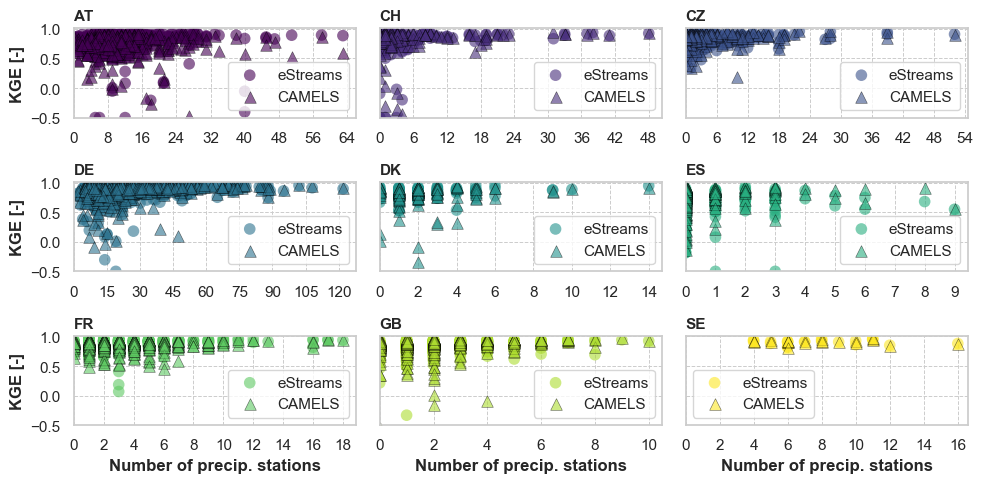

In [23]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import numpy as np

# Set Seaborn style
sns.set(style="whitegrid", font_scale=1.0)

df = network_basins.copy()

# Clip values
df["estreams_kges"] = df["estreams_kges"].clip(lower=-0.5, upper=1.0)

# Get unique color groups
groups = df['color'].unique()
n_groups = len(groups)

# Map each color to its corresponding gauge_country
color_to_country = df.drop_duplicates('color').set_index('color')['gauge_country'].to_dict()

# Generate professional color palette (Spectral is good for diverging data)
cmap = cm.get_cmap("viridis", n_groups)
new_colors = [mcolors.to_hex(cmap(i)) for i in range(n_groups)]
group_to_color = dict(zip(groups, new_colors))

# Set up subplot grid
n_cols = 3
n_rows = (n_groups + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 5), sharex=False, sharey=True)
axes = axes.flatten()

for i, color in enumerate(groups):
    group_df = df[df['color'] == color]
    country = color_to_country[color]
    plot_color = group_to_color[color]

    # Plot eStreams KGE as circles
    sns.scatterplot(
        ax=axes[i],
        x=group_df["stations_num_p_mean"],
        y=group_df["estreams_kges"],
        color=plot_color,
        edgecolor='none',
        s=70,
        alpha=0.6,
        marker='o',
        label='eStreams'
    )

    # Plot CAMELS KGE as triangles
    sns.scatterplot(
        ax=axes[i],
        x=group_df["stations_num_p_mean"],
        y=group_df["camels_kges"],
        color=plot_color,
        edgecolor='black',
        linewidth=0.4,
        s=70,
        alpha=0.6,
        marker='^',
        label='CAMELS'
    )


    axes[i].set_title(f"{country}", fontsize=11, fontweight="bold", loc="left")
    
    if i // n_cols == n_rows - 1:
        axes[i].set_xlabel("Number of precip. stations", fontweight="bold")
    else:
        axes[i].set_xlabel("")

    if i % n_cols == 0:
        axes[i].set_ylabel(r"KGE [-]", fontweight="bold")
    else:
        axes[i].set_ylabel("")

    axes[i].set_ylim(-0.5, 1.01)
    axes[i].set_xlim(left=0)
    axes[i].xaxis.set_major_locator(mticker.MaxNLocator(integer=True))

    #axes[i].axhline(0, color='black', linestyle='--', linewidth=1)
    #axes[i].axhline(-0.3, color='black', linestyle='--', linewidth=1)
    #axes[i].axhline(0.3, color='black', linestyle='--', linewidth=1)
    #axes[i].set_yticks([-0.3, -0.15, 0, 0.15, 0.3])
    axes[i].set_yticks([-0.5, 0, 0.5, 1.0])

    axes[i].grid(True, which='both', linestyle='--', linewidth=0.7)

    ## Annotate counts
    #n_above = (group_df['diff'] > 0).sum()
    #n_below = (group_df['diff'] < 0).sum()

    #axes[i].text(
    #    0.98, 0.9,
    #    f"n={n_above}",
    #    transform=axes[i].transAxes,
    #    ha="right", va="top",
    #    fontsize=10, fontweight="bold"
    #)

    #axes[i].text(
    #    0.98, 0.1,
    #    f"n={n_below}",
    #    transform=axes[i].transAxes,
    #    ha="right", va="bottom",
    #    fontsize=10, fontweight="bold"
    #)

# Delete unused axes
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Layout adjustments
plt.tight_layout()
plt.savefig("results/figs/kge_scatters_pstations_nseestreamscamels.png", dpi=300, bbox_inches='tight')
plt.show()

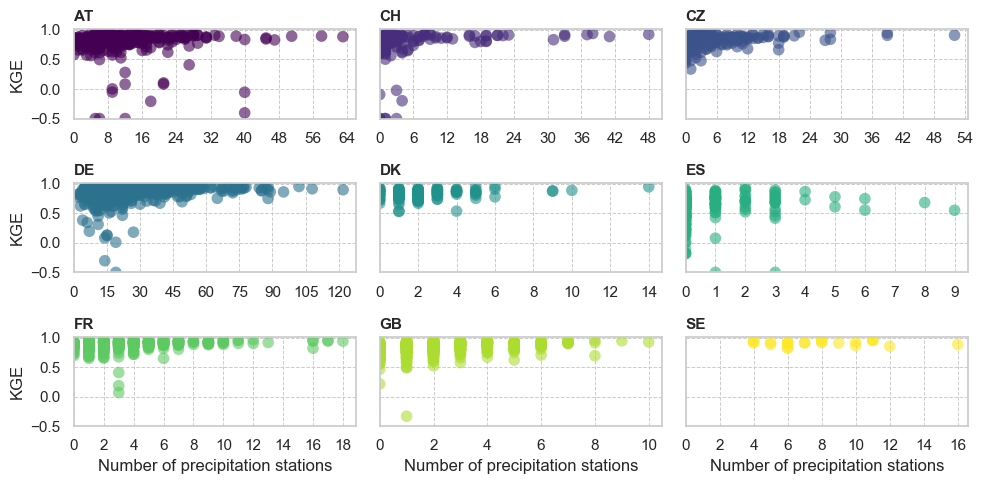

In [72]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import numpy as np

# Set Seaborn style
sns.set(style="whitegrid", font_scale=1.0)

df = network_basins.copy()

# Clip values
df["estreams_kges"] = df["estreams_kges"].clip(lower=-0.5, upper=1.0)

# Get unique color groups
groups = df['color'].unique()
n_groups = len(groups)

# Map each color to its corresponding gauge_country
color_to_country = df.drop_duplicates('color').set_index('color')['gauge_country'].to_dict()

# Generate professional color palette (Spectral is good for diverging data)
cmap = cm.get_cmap("viridis", n_groups)
new_colors = [mcolors.to_hex(cmap(i)) for i in range(n_groups)]
group_to_color = dict(zip(groups, new_colors))

# Set up subplot grid
n_cols = 3
n_rows = (n_groups + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 5), sharex=False, sharey=True)
axes = axes.flatten()

for i, color in enumerate(groups):
    group_df = df[df['color'] == color]
    country = color_to_country[color]
    plot_color = group_to_color[color]

    # Use seaborn scatterplot for consistency
    sns.scatterplot(
        ax=axes[i],
        x=group_df["stations_num_p_mean"],
        y=group_df["estreams_kges"],
        color=plot_color,
        edgecolor='none',
        s=70,
        alpha=0.6
    )

    axes[i].set_title(f"{country}", fontsize=11, fontweight="bold", loc="left")
    
    if i // n_cols == n_rows - 1:
        axes[i].set_xlabel("Number of precipitation stations")
    else:
        axes[i].set_xlabel("")

    if i % n_cols == 0:
        axes[i].set_ylabel(r"KGE")
    else:
        axes[i].set_ylabel("")

    axes[i].set_ylim(-0.5, 1.01)
    axes[i].set_xlim(left=0)
    axes[i].xaxis.set_major_locator(mticker.MaxNLocator(integer=True))

    #axes[i].axhline(0, color='black', linestyle='--', linewidth=1)
    #axes[i].axhline(-0.3, color='black', linestyle='--', linewidth=1)
    #axes[i].axhline(0.3, color='black', linestyle='--', linewidth=1)
    #axes[i].set_yticks([-0.3, -0.15, 0, 0.15, 0.3])
    axes[i].set_yticks([-0.5, 0, 0.5, 1.0])

    axes[i].grid(True, which='both', linestyle='--', linewidth=0.7)

    ## Annotate counts
    #n_above = (group_df['diff'] > 0).sum()
    #n_below = (group_df['diff'] < 0).sum()

    #axes[i].text(
    #    0.98, 0.9,
    #    f"n={n_above}",
    #    transform=axes[i].transAxes,
    #    ha="right", va="top",
    #    fontsize=10, fontweight="bold"
    #)

    #axes[i].text(
    #    0.98, 0.1,
    #    f"n={n_below}",
    #    transform=axes[i].transAxes,
    #    ha="right", va="bottom",
    #    fontsize=10, fontweight="bold"
    #)

# Delete unused axes
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Layout adjustments
plt.tight_layout()
plt.savefig("results/figs/kge_scatters_pstations_nseestreams.png", dpi=300, bbox_inches='tight')
plt.show()

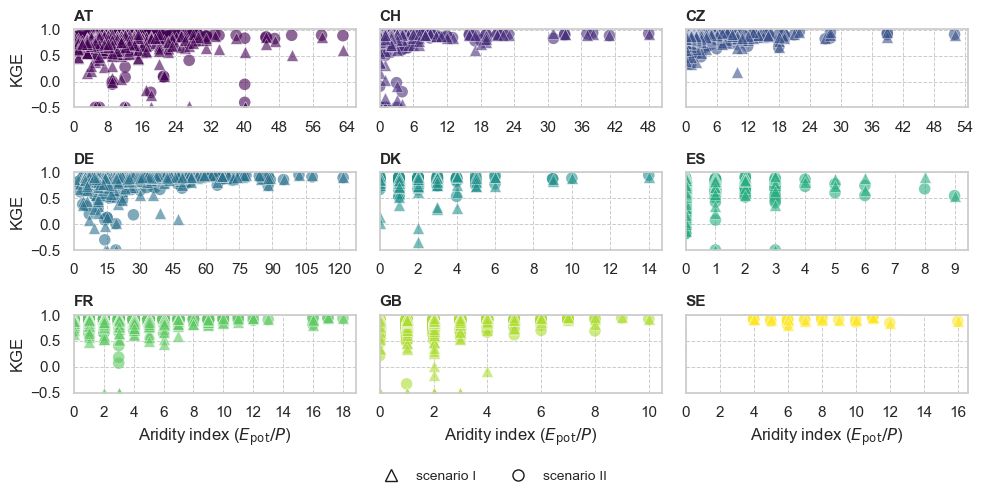

In [64]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import numpy as np

# Set Seaborn style
sns.set(style="whitegrid", font_scale=1.0)

df = network_basins.copy()

# Clip values
df["estreams_kges"] = df["estreams_kges"].clip(lower=-0.5, upper=1.0)
df["camels_kges"] = df["camels_kges"].clip(lower=-0.5, upper=1.0)

# Get unique color groups
groups = df['color'].unique()
n_groups = len(groups)

# Map each color to its corresponding gauge_country
color_to_country = df.drop_duplicates('color').set_index('color')['gauge_country'].to_dict()

# Generate professional color palette (Spectral is good for diverging data)
cmap = cm.get_cmap("viridis", n_groups)
new_colors = [mcolors.to_hex(cmap(i)) for i in range(n_groups)]
group_to_color = dict(zip(groups, new_colors))

# Set up subplot grid
n_cols = 3
n_rows = (n_groups + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 5), sharex=False, sharey=True)
axes = axes.flatten()

for i, color in enumerate(groups):
    group_df = df[df['color'] == color]
    country = color_to_country[color]
    plot_color = group_to_color[color]

    # Plot eStreams KGE as circles
    sns.scatterplot(
        ax=axes[i],
        x=group_df["stations_num_p_mean"],
        y=group_df["estreams_kges"],
        color=plot_color,
        edgecolor='none',
        s=70,
        alpha=0.6,
        marker='o',
        legend = False
    )

    # Plot CAMELS KGE as triangles
    sns.scatterplot(
        ax=axes[i],
        x=group_df["stations_num_p_mean"],
        y=group_df["camels_kges"],
        color=plot_color,
        edgecolor='white',
        linewidth=0.4,
        s=70,
        alpha=0.6,
        marker='^',
        legend = False

    )

    axes[i].set_title(f"{country}", fontsize=11, fontweight="bold", loc="left")
    
    if i // n_cols == n_rows - 1:
        axes[i].set_xlabel(r"Aridity index ($E_{\mathrm{pot}}/P$)")
    else:
        axes[i].set_xlabel("")

    if i % n_cols == 0:
        axes[i].set_ylabel(r"KGE")
    else:
        axes[i].set_ylabel("")

    axes[i].set_ylim(-0.5, 1.01)
    axes[i].set_xlim(left=0)
    axes[i].xaxis.set_major_locator(mticker.MaxNLocator(integer=True))
    axes[i].set_yticks([-0.5, 0, 0.5, 1.0])
    axes[i].grid(True, which='both', linestyle='--', linewidth=0.7)

# Delete unused axes
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

from matplotlib.lines import Line2D

# Custom legend handles
legend_elements = [

    Line2D([0], [0], marker='^', color='k', label='scenario I',
           markerfacecolor='none', markersize=8, linestyle='None', linewidth=0.5),

    Line2D([0], [0], marker='o', color='k', label='scenario II',
           markerfacecolor='none', markersize=8, linestyle='None', linewidth=0.5)

]

# Add manual legend below plots
fig.legend(
    handles=legend_elements,
    loc='lower center',
    ncol=2,
    fontsize=10,
    frameon=False
)


# Layout adjustments
plt.tight_layout(rect=[0, 0.05, 1, 1])  # Leave space at bottom for legend
plt.savefig("results/figs/KGE_pstations_scenario_I_II.png", dpi=300, bbox_inches='tight')
plt.show()


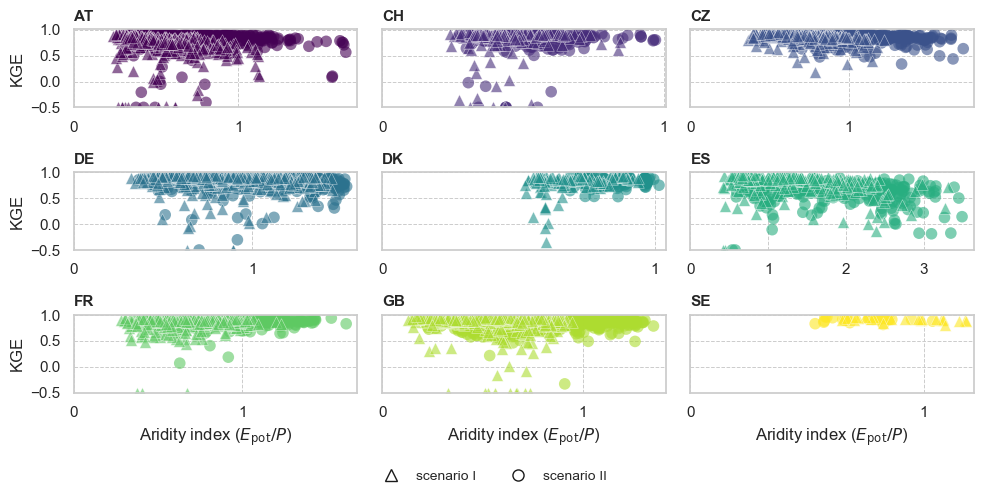

In [67]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import numpy as np

# Set Seaborn style
sns.set(style="whitegrid", font_scale=1.0)

df = network_basins.copy()

# Clip values
df["estreams_kges"] = df["estreams_kges"].clip(lower=-0.5, upper=1.0)
df["camels_kges"] = df["camels_kges"].clip(lower=-0.5, upper=1.0)

# Get unique color groups
groups = df['color'].unique()
n_groups = len(groups)

# Map each color to its corresponding gauge_country
color_to_country = df.drop_duplicates('color').set_index('color')['gauge_country'].to_dict()

# Generate professional color palette (Spectral is good for diverging data)
cmap = cm.get_cmap("viridis", n_groups)
new_colors = [mcolors.to_hex(cmap(i)) for i in range(n_groups)]
group_to_color = dict(zip(groups, new_colors))

# Set up subplot grid
n_cols = 3
n_rows = (n_groups + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 5), sharex=False, sharey=True)
axes = axes.flatten()

for i, color in enumerate(groups):
    group_df = df[df['color'] == color]
    country = color_to_country[color]
    plot_color = group_to_color[color]

    # Plot eStreams KGE as circles
    sns.scatterplot(
        ax=axes[i],
        x=group_df["aridity_estreams"],
        y=group_df["estreams_kges"],
        color=plot_color,
        edgecolor='none',
        s=70,
        alpha=0.6,
        marker='o',
        legend = False
    )

    # Plot CAMELS KGE as triangles
    sns.scatterplot(
        ax=axes[i],
        x=group_df["aridity_camels"],
        y=group_df["camels_kges"],
        color=plot_color,
        edgecolor='white',
        linewidth=0.4,
        s=70,
        alpha=0.6,
        marker='^',
        legend = False

    )

    axes[i].set_title(f"{country}", fontsize=11, fontweight="bold", loc="left")
    
    if i // n_cols == n_rows - 1:
        axes[i].set_xlabel(r"Aridity index ($E_{\mathrm{pot}}/P$)")
    else:
        axes[i].set_xlabel("")

    if i % n_cols == 0:
        axes[i].set_ylabel(r"KGE")
    else:
        axes[i].set_ylabel("")

    axes[i].set_ylim(-0.5, 1.01)
    axes[i].set_xlim(left=0)
    axes[i].xaxis.set_major_locator(mticker.MaxNLocator(integer=True))
    axes[i].set_yticks([-0.5, 0, 0.5, 1.0])
    axes[i].grid(True, which='both', linestyle='--', linewidth=0.7)

# Delete unused axes
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

from matplotlib.lines import Line2D

# Custom legend handles
legend_elements = [

    Line2D([0], [0], marker='^', color='k', label='scenario I',
           markerfacecolor='none', markersize=8, linestyle='None', linewidth=0.5),

    Line2D([0], [0], marker='o', color='k', label='scenario II',
           markerfacecolor='none', markersize=8, linestyle='None', linewidth=0.5)

]

# Add manual legend below plots
fig.legend(
    handles=legend_elements,
    loc='lower center',
    ncol=2,
    fontsize=10,
    frameon=False
)


# Layout adjustments
plt.tight_layout(rect=[0, 0.05, 1, 1])  # Leave space at bottom for legend
plt.savefig("results/figs/KGE_atidity_scenario_I_II.png", dpi=300, bbox_inches='tight')
plt.show()


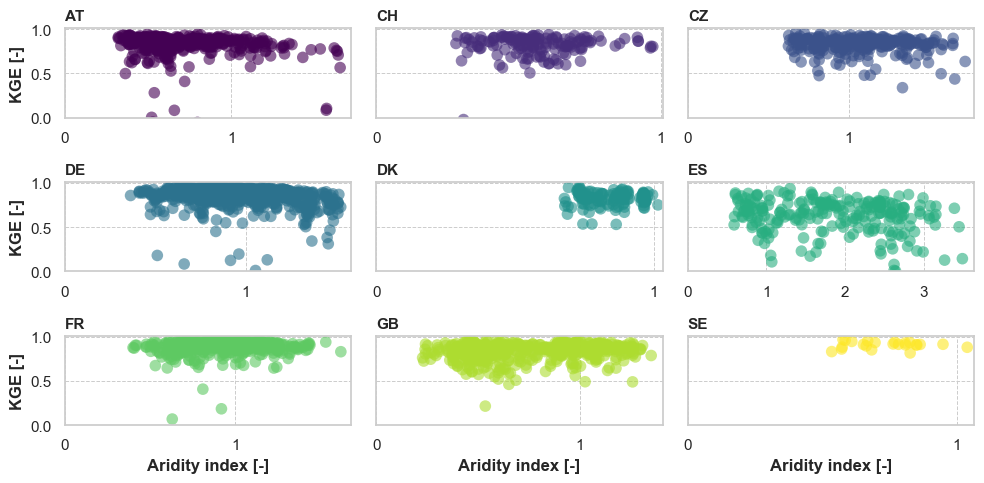

In [48]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import numpy as np
from sklearn.metrics import r2_score

# Set Seaborn style
sns.set(style="whitegrid", font_scale=1.0)

df = network_basins.copy()

# Clip values
df["estreams_kges"] = df["estreams_kges"].clip(lower=-0.5, upper=1.0)

# Get unique color groups
groups = df['color'].unique()
n_groups = len(groups)

# Map each color to its corresponding gauge_country
color_to_country = df.drop_duplicates('color').set_index('color')['gauge_country'].to_dict()

# Generate professional color palette (Spectral is good for diverging data)
cmap = cm.get_cmap("viridis", n_groups)
new_colors = [mcolors.to_hex(cmap(i)) for i in range(n_groups)]
group_to_color = dict(zip(groups, new_colors))

# Set up subplot grid
n_cols = 3
n_rows = (n_groups + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 5), sharex=False, sharey=True)
axes = axes.flatten()

for i, color in enumerate(groups):
    group_df = df[df['color'] == color]
    country = color_to_country[color]
    plot_color = group_to_color[color]

    # Use seaborn scatterplot for consistency
    sns.scatterplot(
        ax=axes[i],
        x=group_df["aridity_estreams"],
        y=group_df["estreams_kges"],
        color=plot_color,
        edgecolor='none',
        s=70,
        alpha=0.6
    )

    axes[i].set_title(f"{country}", fontsize=11, fontweight="bold", loc="left")
    
    if i // n_cols == n_rows - 1:
        axes[i].set_xlabel("Aridity index [-]", fontweight="bold")
    else:
        axes[i].set_xlabel("")

    if i % n_cols == 0:
        axes[i].set_ylabel(r"KGE [-]", fontweight="bold")
    else:
        axes[i].set_ylabel("")

    axes[i].set_ylim(0.0, 1.01)
    axes[i].set_xlim(left=0)
    axes[i].xaxis.set_major_locator(mticker.MaxNLocator(integer=True))

    #axes[i].axhline(0, color='black', linestyle='--', linewidth=1)
    #axes[i].axhline(-0.3, color='black', linestyle='--', linewidth=1)
    #axes[i].axhline(0.3, color='black', linestyle='--', linewidth=1)
    #axes[i].set_yticks([-0.3, -0.15, 0, 0.15, 0.3])
    axes[i].set_yticks([0, 0.5, 1.0])

    axes[i].grid(True, which='both', linestyle='--', linewidth=0.7)

    ## Annotate counts
    #n_above = (group_df['diff'] > 0).sum()
    #n_below = (group_df['diff'] < 0).sum()

    #axes[i].text(
    #    0.98, 0.9,
    #    f"n={n_above}",
    #    transform=axes[i].transAxes,
    #    ha="right", va="top",
    #    fontsize=10, fontweight="bold"
    #)

    #axes[i].text(
    #    0.98, 0.1,
    #    f"n={n_below}",
    #    transform=axes[i].transAxes,
    #    ha="right", va="bottom",
    #    fontsize=10, fontweight="bold"
    #)

# Delete unused axes
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Layout adjustments
plt.tight_layout()
plt.savefig("results/figs/kge_scatters_aridityindex_nseestreams.png", dpi=300, bbox_inches='tight')
plt.show()

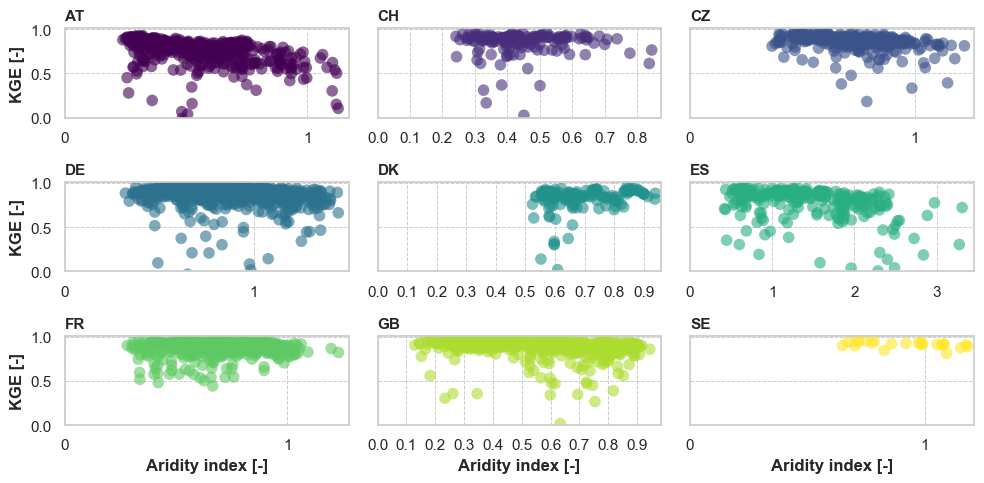

In [59]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import numpy as np

# Set Seaborn style
sns.set(style="whitegrid", font_scale=1.0)

df = network_basins.copy()

# Clip values
df["camels_kges"] = df["camels_kges"].clip(lower=-0.5, upper=1.0)

# Get unique color groups
groups = df['color'].unique()
n_groups = len(groups)

# Map each color to its corresponding gauge_country
color_to_country = df.drop_duplicates('color').set_index('color')['gauge_country'].to_dict()

# Generate professional color palette (Spectral is good for diverging data)
cmap = cm.get_cmap("viridis", n_groups)
new_colors = [mcolors.to_hex(cmap(i)) for i in range(n_groups)]
group_to_color = dict(zip(groups, new_colors))

# Set up subplot grid
n_cols = 3
n_rows = (n_groups + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 5), sharex=False, sharey=True)
axes = axes.flatten()

for i, color in enumerate(groups):
    group_df = df[df['color'] == color]
    country = color_to_country[color]
    plot_color = group_to_color[color]

    # Use seaborn scatterplot for consistency
    sns.scatterplot(
        ax=axes[i],
        x=group_df["aridity_camels"],
        y=group_df["camels_kges"],
        color=plot_color,
        edgecolor='none',
        s=70,
        alpha=0.6
    )

    axes[i].set_title(f"{country}", fontsize=11, fontweight="bold", loc="left")
    
    if i // n_cols == n_rows - 1:
        axes[i].set_xlabel("Aridity index [-]", fontweight="bold")
    else:
        axes[i].set_xlabel("")

    if i % n_cols == 0:
        axes[i].set_ylabel(r"KGE [-]", fontweight="bold")
    else:
        axes[i].set_ylabel("")

    axes[i].set_ylim(0.0, 1.01)
    axes[i].set_xlim(left=0)
    axes[i].xaxis.set_major_locator(mticker.MaxNLocator(integer=True))

    #axes[i].axhline(0, color='black', linestyle='--', linewidth=1)
    #axes[i].axhline(-0.3, color='black', linestyle='--', linewidth=1)
    #axes[i].axhline(0.3, color='black', linestyle='--', linewidth=1)
    #axes[i].set_yticks([-0.3, -0.15, 0, 0.15, 0.3])
    axes[i].set_yticks([0, 0.5, 1.0])

    axes[i].grid(True, which='both', linestyle='--', linewidth=0.7)

    ## Annotate counts
    #n_above = (group_df['diff'] > 0).sum()
    #n_below = (group_df['diff'] < 0).sum()

    #axes[i].text(
    #    0.98, 0.9,
    #    f"n={n_above}",
    #    transform=axes[i].transAxes,
    #    ha="right", va="top",
    #    fontsize=10, fontweight="bold"
    #)

    #axes[i].text(
    #    0.98, 0.1,
    #    f"n={n_below}",
    #    transform=axes[i].transAxes,
    #    ha="right", va="bottom",
    #    fontsize=10, fontweight="bold"
    #)

# Delete unused axes
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Layout adjustments
plt.tight_layout()
plt.savefig("results/figs/kge_scatters_aridityindex_nsecamels.png", dpi=300, bbox_inches='tight')
plt.show()

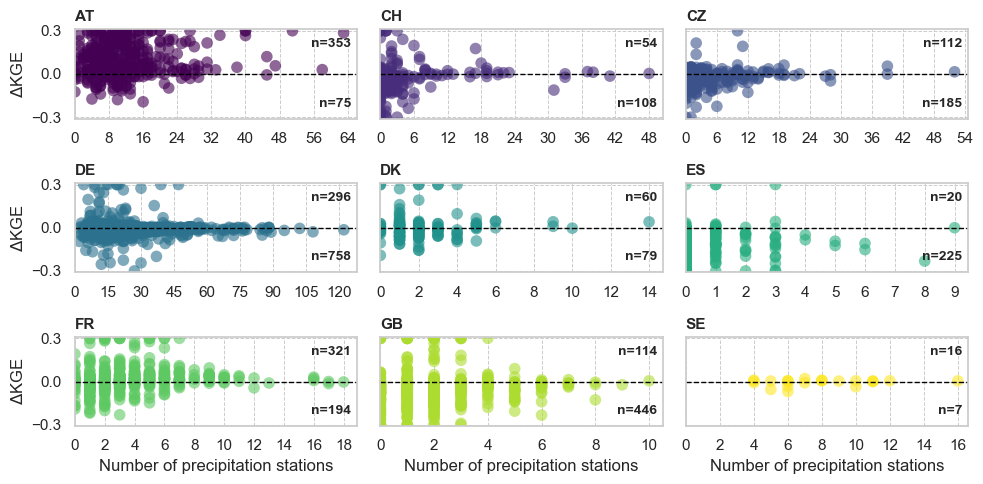

In [73]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import numpy as np

# Set Seaborn style
sns.set(style="whitegrid", font_scale=1.0)

df = network_basins.copy()

# Clip values
df["diff"] = df["diff"].clip(lower=-0.3, upper=0.3)

# Get unique color groups
groups = df['color'].unique()
n_groups = len(groups)

# Map each color to its corresponding gauge_country
color_to_country = df.drop_duplicates('color').set_index('color')['gauge_country'].to_dict()

# Generate professional color palette (Spectral is good for diverging data)
cmap = cm.get_cmap("viridis", n_groups)
new_colors = [mcolors.to_hex(cmap(i)) for i in range(n_groups)]
group_to_color = dict(zip(groups, new_colors))

# Set up subplot grid
n_cols = 3
n_rows = (n_groups + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 5), sharex=False, sharey=True)
axes = axes.flatten()

for i, color in enumerate(groups):
    group_df = df[df['color'] == color]
    country = color_to_country[color]
    plot_color = group_to_color[color]

    # Use seaborn scatterplot for consistency
    sns.scatterplot(
        ax=axes[i],
        x=group_df["stations_num_p_mean"],
        y=group_df["diff"],
        color=plot_color,
        edgecolor='none',
        s=70,
        alpha=0.6
    )

    axes[i].set_title(f"{country}", fontsize=11, fontweight="bold", loc="left")
    
    if i // n_cols == n_rows - 1:
        axes[i].set_xlabel("Number of precipitation stations")
    else:
        axes[i].set_xlabel("")

    if i % n_cols == 0:
        axes[i].set_ylabel(r"$\Delta$KGE")
    else:
        axes[i].set_ylabel("")

    axes[i].set_ylim(-0.31, 0.31)
    axes[i].set_xlim(left=0)
    axes[i].xaxis.set_major_locator(mticker.MaxNLocator(integer=True))

    axes[i].axhline(0, color='black', linestyle='--', linewidth=1)
    #axes[i].axhline(-0.3, color='black', linestyle='--', linewidth=1)
    #axes[i].axhline(0.3, color='black', linestyle='--', linewidth=1)
    #axes[i].set_yticks([-0.3, -0.15, 0, 0.15, 0.3])
    axes[i].set_yticks([-0.3, 0, 0.3])

    axes[i].grid(True, which='both', linestyle='--', linewidth=0.7)

    # Annotate counts
    n_above = (group_df['diff'] > 0).sum()
    n_below = (group_df['diff'] < 0).sum()

    axes[i].text(
        0.98, 0.9,
        f"n={n_above}",
        transform=axes[i].transAxes,
        ha="right", va="top",
        fontsize=10, fontweight="bold"
    )

    axes[i].text(
        0.98, 0.1,
        f"n={n_below}",
        transform=axes[i].transAxes,
        ha="right", va="bottom",
        fontsize=10, fontweight="bold"
    )

# Delete unused axes
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Layout adjustments
plt.tight_layout()
plt.savefig("results/figs/kge_scatters_pstations.png", dpi=300, bbox_inches='tight')
plt.show()

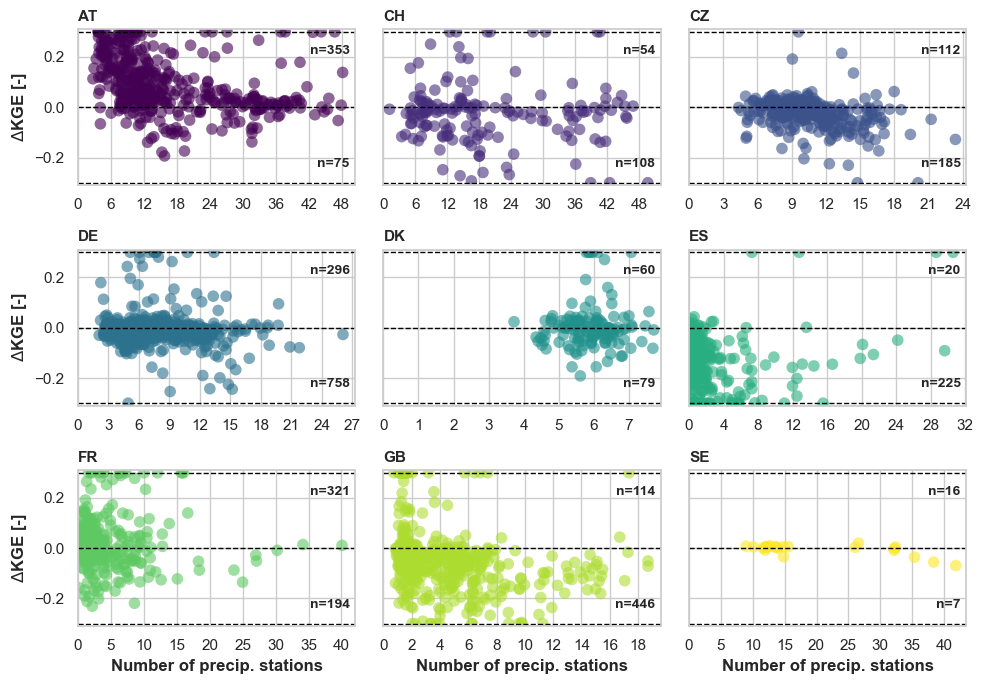

In [69]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import numpy as np

# Set Seaborn style
sns.set(style="whitegrid", font_scale=1.0)

df = network_basins.copy()

# Clip values
df["diff"] = df["diff"].clip(lower=-0.3, upper=0.3)

# Get unique color groups
groups = df['color'].unique()
n_groups = len(groups)

# Map each color to its corresponding gauge_country
color_to_country = df.drop_duplicates('color').set_index('color')['gauge_country'].to_dict()

# Generate professional color palette (Spectral is good for diverging data)
cmap = cm.get_cmap("viridis", n_groups)
new_colors = [mcolors.to_hex(cmap(i)) for i in range(n_groups)]
group_to_color = dict(zip(groups, new_colors))

# Set up subplot grid
n_cols = 3
n_rows = (n_groups + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 7), sharex=False, sharey=True)
axes = axes.flatten()

for i, color in enumerate(groups):
    group_df = df[df['color'] == color]
    country = color_to_country[color]
    plot_color = group_to_color[color]

    # Use seaborn scatterplot for consistency
    sns.scatterplot(
        ax=axes[i],
        x=group_df["sno_cov_mean"],
        y=group_df["diff"],
        color=plot_color,
        edgecolor='none',
        s=70,
        alpha=0.6
    )

    axes[i].set_title(f"{country}", fontsize=11, fontweight="bold", loc="left")
    
    if i // n_cols == n_rows - 1:
        axes[i].set_xlabel("Number of precip. stations", fontweight="bold")
    else:
        axes[i].set_xlabel("")

    if i % n_cols == 0:
        axes[i].set_ylabel(r"$\Delta$KGE [-]", fontweight="bold")
    else:
        axes[i].set_ylabel("")

    axes[i].set_ylim(-0.31, 0.31)
    axes[i].set_xlim(left=0)
    axes[i].xaxis.set_major_locator(mticker.MaxNLocator(integer=True))

    axes[i].axhline(0, color='black', linestyle='--', linewidth=1)
    axes[i].axhline(-0.3, color='black', linestyle='--', linewidth=1)
    axes[i].axhline(0.3, color='black', linestyle='--', linewidth=1)

    # Annotate counts
    n_above = (group_df['diff'] > 0).sum()
    n_below = (group_df['diff'] < 0).sum()

    axes[i].text(
        0.98, 0.9,
        f"n={n_above}",
        transform=axes[i].transAxes,
        ha="right", va="top",
        fontsize=10, fontweight="bold"
    )

    axes[i].text(
        0.98, 0.1,
        f"n={n_below}",
        transform=axes[i].transAxes,
        ha="right", va="bottom",
        fontsize=10, fontweight="bold"
    )

# Delete unused axes
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Layout adjustments
plt.tight_layout()
plt.savefig("results/figs/kge_scatters_sno_cov_mean.png", dpi=300, bbox_inches='tight')
plt.show()

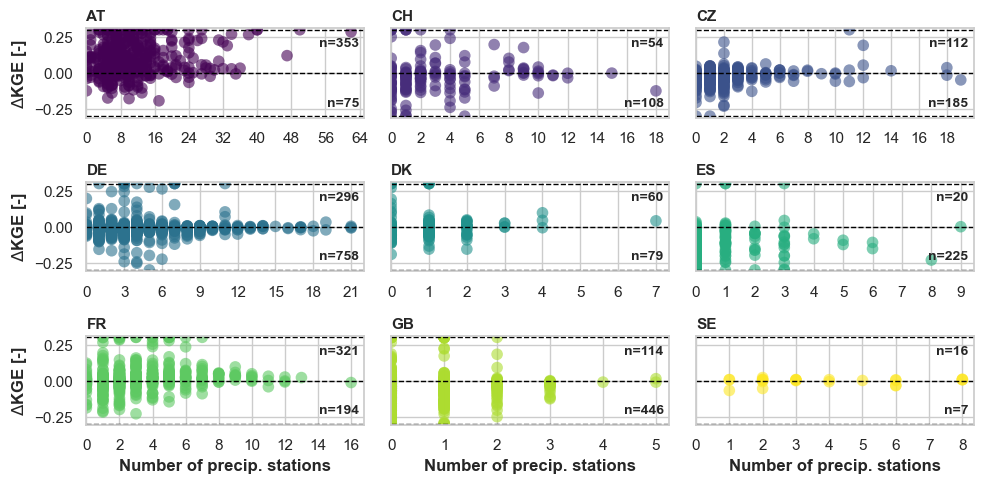

In [39]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import numpy as np

# Set Seaborn style
sns.set(style="whitegrid", font_scale=1.0)

df = network_basins.copy()

# Clip values
df["diff"] = df["diff"].clip(lower=-0.3, upper=0.3)

# Get unique color groups
groups = df['color'].unique()
n_groups = len(groups)

# Map each color to its corresponding gauge_country
color_to_country = df.drop_duplicates('color').set_index('color')['gauge_country'].to_dict()

# Generate professional color palette (Spectral is good for diverging data)
cmap = cm.get_cmap("viridis", n_groups)
new_colors = [mcolors.to_hex(cmap(i)) for i in range(n_groups)]
group_to_color = dict(zip(groups, new_colors))

# Set up subplot grid
n_cols = 3
n_rows = (n_groups + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 5), sharex=False, sharey=True)
axes = axes.flatten()

for i, color in enumerate(groups):
    group_df = df[df['color'] == color]
    country = color_to_country[color]
    plot_color = group_to_color[color]

    # Use seaborn scatterplot for consistency
    sns.scatterplot(
        ax=axes[i],
        x=group_df["stations_num_t_mean"],
        y=group_df["diff"],
        color=plot_color,
        edgecolor='none',
        s=70,
        alpha=0.6
    )

    axes[i].set_title(f"{country}", fontsize=11, fontweight="bold", loc="left")
    
    if i // n_cols == n_rows - 1:
        axes[i].set_xlabel("Number of precip. stations", fontweight="bold")
    else:
        axes[i].set_xlabel("")

    if i % n_cols == 0:
        axes[i].set_ylabel(r"$\Delta$KGE [-]", fontweight="bold")
    else:
        axes[i].set_ylabel("")

    axes[i].set_ylim(-0.31, 0.31)
    axes[i].set_xlim(left=0)
    axes[i].xaxis.set_major_locator(mticker.MaxNLocator(integer=True))

    axes[i].axhline(0, color='black', linestyle='--', linewidth=1)
    axes[i].axhline(-0.3, color='black', linestyle='--', linewidth=1)
    axes[i].axhline(0.3, color='black', linestyle='--', linewidth=1)

    # Annotate counts
    n_above = (group_df['diff'] > 0).sum()
    n_below = (group_df['diff'] < 0).sum()

    axes[i].text(
        0.98, 0.9,
        f"n={n_above}",
        transform=axes[i].transAxes,
        ha="right", va="top",
        fontsize=10, fontweight="bold"
    )

    axes[i].text(
        0.98, 0.1,
        f"n={n_below}",
        transform=axes[i].transAxes,
        ha="right", va="bottom",
        fontsize=10, fontweight="bold"
    )

# Delete unused axes
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Layout adjustments
plt.tight_layout()
plt.savefig("results/figs/kge_scatters_stations_num_t_mean.png", dpi=300, bbox_inches='tight')
plt.show()

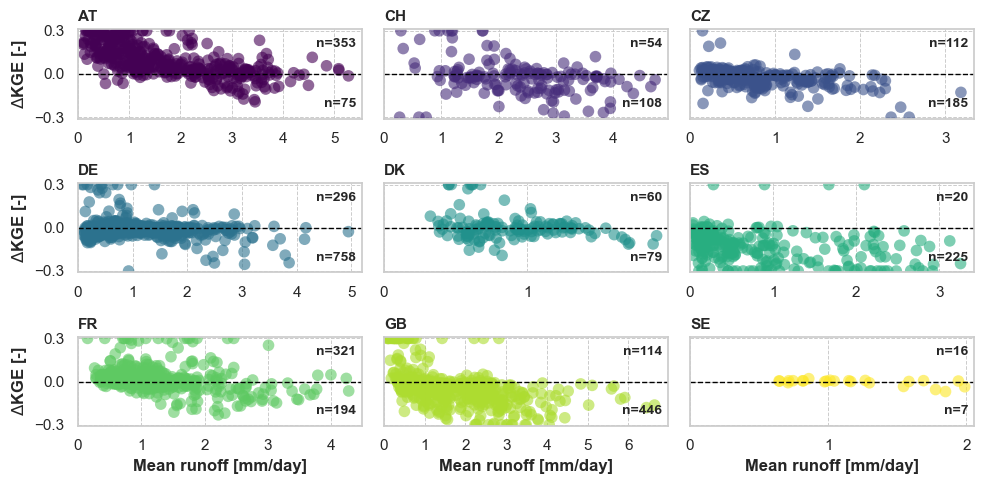

In [38]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import numpy as np

# Set Seaborn style
sns.set(style="whitegrid", font_scale=1.0)

df = network_basins.copy()

# Clip values
df["diff"] = df["diff"].clip(lower=-0.3, upper=0.3)

# Get unique color groups
groups = df['color'].unique()
n_groups = len(groups)

# Map each color to its corresponding gauge_country
color_to_country = df.drop_duplicates('color').set_index('color')['gauge_country'].to_dict()

# Generate professional color palette (Spectral is good for diverging data)
cmap = cm.get_cmap("viridis", n_groups)
new_colors = [mcolors.to_hex(cmap(i)) for i in range(n_groups)]
group_to_color = dict(zip(groups, new_colors))

# Set up subplot grid
n_cols = 3
n_rows = (n_groups + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 5), sharex=False, sharey=True)
axes = axes.flatten()

for i, color in enumerate(groups):
    group_df = df[df['color'] == color]
    country = color_to_country[color]
    plot_color = group_to_color[color]

    # Use seaborn scatterplot for consistency
    sns.scatterplot(
        ax=axes[i],
        x=group_df["q_mean"],
        y=group_df["diff"],
        color=plot_color,
        edgecolor='none',
        s=70,
        alpha=0.6
    )

    axes[i].set_title(f"{country}", fontsize=11, fontweight="bold", loc="left")
    
    if i // n_cols == n_rows - 1:
        axes[i].set_xlabel("Mean runoff [mm/day]", fontweight="bold")
    else:
        axes[i].set_xlabel("")

    if i % n_cols == 0:
        axes[i].set_ylabel(r"$\Delta$KGE [-]", fontweight="bold")
    else:
        axes[i].set_ylabel("")

    axes[i].set_ylim(-0.31, 0.31)
    axes[i].set_xlim(left=0)
    axes[i].xaxis.set_major_locator(mticker.MaxNLocator(integer=True))

    axes[i].axhline(0, color='black', linestyle='--', linewidth=1)
    #axes[i].axhline(-0.3, color='black', linestyle='--', linewidth=1)
    #axes[i].axhline(0.3, color='black', linestyle='--', linewidth=1)
    #axes[i].set_yticks([-0.3, -0.15, 0, 0.15, 0.3])
    axes[i].set_yticks([-0.3, 0, 0.3])

    axes[i].grid(True, which='both', linestyle='--', linewidth=0.7)

    # Annotate counts
    n_above = (group_df['diff'] > 0).sum()
    n_below = (group_df['diff'] < 0).sum()

    axes[i].text(
        0.98, 0.9,
        f"n={n_above}",
        transform=axes[i].transAxes,
        ha="right", va="top",
        fontsize=10, fontweight="bold"
    )

    axes[i].text(
        0.98, 0.1,
        f"n={n_below}",
        transform=axes[i].transAxes,
        ha="right", va="bottom",
        fontsize=10, fontweight="bold"
    )

# Delete unused axes
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Layout adjustments
plt.tight_layout()
plt.savefig("results/figs/kge_scatters_qmean.png", dpi=300, bbox_inches='tight')
plt.show()

In [106]:
correlations_df[abs(correlations_df)>0.05]

q_mean                      -0.186068
q_runoff_ratio              -0.311866
q_elas_Sankarasubramanian    0.108183
slope_sawicz                -0.148865
baseflow_index               0.114256
hfd_mean                     0.156650
q_5                         -0.055784
q_95                        -0.198454
hq_freq                     -0.054444
lq_freq                     -0.099526
lq_dur                      -0.108054
zero_q_freq                 -0.085741
p_mean                       0.063268
pet_mean                     0.109929
p_seasonality                0.287323
frac_snow                    0.134098
hp_freq                      0.125095
hp_time                      0.148412
lp_freq                      0.057716
lp_time                     -0.180671
ele_mt_min                   0.055482
slp_dg_mean                 -0.051480
flat_area_fra                0.052502
steep_area_fra              -0.057789
root_dep_mean               -0.061335
root_dep_max                -0.285569
root_dep_min

In [68]:
network_basins.iloc[:, 47:].corr(method="pearson")["aridity_camels"]

q_mean                      -0.680234
q_runoff_ratio              -0.653136
q_elas_Sankarasubramanian    0.311492
slope_sawicz                 0.077497
baseflow_index               0.099688
                               ...   
diff                        -0.065615
estreams_kges               -0.126976
camels_kges                 -0.018068
aridity_estreams             0.929920
aridity_camels               1.000000
Name: aridity_camels, Length: 64, dtype: float64

In [ ]:
correlations_df = network_basins.iloc[:, 47:].corr(method="spearman")["estreams_kges"]

correlations_df[abs(correlations_df)>0.1]

hfd_mean                -0.209613
hfd_std                 -0.191283
hq_freq                 -0.211291
hq_dur                  -0.156536
lq_freq                 -0.150360
lq_dur                  -0.158637
zero_q_freq             -0.167302
pet_mean                -0.111950
aridity                 -0.168055
frac_snow               -0.130415
hp_freq                 -0.129156
hp_dur                  -0.222992
lp_freq                 -0.144330
lp_dur                  -0.213632
ele_mt_max              -0.231346
ele_mt_mean             -0.242702
ele_mt_min              -0.209309
slp_dg_mean             -0.179065
flat_area_fra            0.110868
steep_area_fra          -0.180346
root_dep_mean            0.145281
soil_fra_grav_mean      -0.113720
lai_mean                 0.181239
ndvi_mean                0.262254
lulc_2006_Agric          0.159759
lulc_2006_grass         -0.290978
lulc_2006_agriculture    0.187556
sno_cov_mean            -0.136179
stations_num_p_mean      0.144571
diff          

In [ ]:
correlations_df = network_basins.iloc[:, 47:].corr(method="spearman")["camels_kges"]

correlations_df[abs(correlations_df)>0.1]

q_mean                   0.280875
q_runoff_ratio           0.319361
slope_sawicz             0.260261
baseflow_index          -0.166062
hfd_mean                -0.421997
hfd_std                 -0.232150
q_95                     0.333709
zero_q_freq             -0.170244
p_mean                   0.150224
pet_mean                -0.224926
aridity                 -0.184885
p_seasonality           -0.335567
frac_snow               -0.202167
hp_freq                 -0.326957
hp_dur                  -0.260213
hp_time                 -0.185337
lp_freq                 -0.317647
lp_dur                  -0.189689
lp_time                  0.192316
ele_mt_max              -0.152571
ele_mt_mean             -0.214705
ele_mt_min              -0.265538
strm_dens                0.179589
soil_tawc_mean           0.158825
soil_oc_mean             0.135243
ndvi_mean                0.234030
lulc_2006_Agric          0.217247
lulc_2006_forest        -0.121457
lulc_2006_agriculture    0.126889
lakes_num     

In [62]:
network_basins

,gauge_id,gauge_name,gauge_country,gauge_provider,river,lon_snap,lat_snap,lon,lat,elevation,...,lakes_tot_area,lakes_tot_vol,sno_cov_mean,stations_num_p_mean,stations_num_t_mean,diff,estreams_kges,camels_kges,aridity_estreams,aridity_camels
id,,,,,,,,,,,,,,,,,,,,,
AT000002,200048,Schruns (Vonbunweg),AT,AT_EHYD,Litz,9.913677,47.080301,9.913677,47.080301,673,...,0.00,0.00,36.284,14.0,13.0,0.006789,0.903629,0.896840,0.387513,0.269834
AT000003,231662,Loruens-Aeule,AT,AT_EHYD,Ill,9.847765,47.132821,9.847765,47.132821,579,...,1.46,12.91,36.927,18.0,18.0,0.606287,-0.208316,-0.814603,0.410328,0.269682
AT000005,200097,Buers (Bruecke L82),AT,AT_EHYD,Alvier,9.802668,47.150770,9.802668,47.150770,564,...,0.89,8.27,34.486,10.0,10.0,0.011733,0.884695,0.872962,0.456838,0.290814
AT000007,231688,Beschling,AT,AT_EHYD,Ill,9.678850,47.200301,9.678850,47.200301,485,...,2.67,23.90,32.887,40.0,38.0,0.266711,0.837836,0.571124,0.415413,0.280518
AT000008,200501,Amerluegen,AT,AT_EHYD,Samina,9.614203,47.205978,9.614203,47.205978,603,...,0.00,0.00,27.201,8.0,6.0,0.235233,0.813583,0.578351,0.487081,0.321851
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SE000091,200,RÖRVIK,SE,SE_SMHI,ALLGUNNEN,14.585100,57.242100,14.585100,57.242100,NaN,...,26.34,184.11,14.816,4.0,1.0,0.006283,0.936235,0.929952,0.824595,0.973800
SE000277,364,HILLARED,SE,SE_SMHI,ÄTRAN,13.141300,57.607300,13.141300,57.607300,NaN,...,50.78,541.40,13.610,12.0,8.0,0.005889,0.852023,0.846135,0.683029,0.826377
SE000283,654,ERSBO,SE,SE_SMHI,VÄSTERDALÄLVEN,13.011000,61.307600,13.011000,61.307600,NaN,...,3.35,14.59,35.366,10.0,6.0,-0.035779,0.861439,0.897218,0.571372,0.702439
